# Disease follow-up analysis

In this notebook we explore targets with different types of evidence for specific diseases.

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

import scipy

In [ ]:
import upsetplot

In [ ]:
import gseapy as gp
from gseapy.plot import barplot, dotplot

names = gp.get_library_name()
gene_sets=['MSigDB_Hallmark_2020', 'GO_Biological_Process_2017', 'GO_Molecular_Function_2017', 
           'GO_Cellular_Component_2017']


In [ ]:
import decoupler as dc
import omnipath as op

In [4]:
import json

import obonet

obo_file = "/nfs/team205/ed6/bin/sc_target_evidence/data/cl.obo"  # downloaded from http://obofoundry.org/ontology/cl.html

# Load the ontology from the OBO file
graph = obonet.read_obo(obo_file)

def ontology2name(o):
    return(graph.nodes.get(o)['name'])

R plotting setup

In [5]:
## r2py setup
# import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [8]:
## Get table of all genes
import genomic_features as gf
import os
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'

## Small molecule / antibody tractable targets
nelson_anno_dataset = data_dir + 'genetic_support/data/gene_lists/' ## Downloaded from https://github.com/ericminikel/genetic_support
gene_annotations = [x for x in os.listdir(nelson_anno_dataset) if x.endswith(".tsv")]

annos = {}
for g in gene_annotations:
    anno_name = g.split(".tsv")[0]
    annos[anno_name] = pd.read_table(nelson_anno_dataset + g, header=None).values.flatten()

ens_ids_to_name = genes[['gene_id', 'gene_name']].copy()
annos.pop('ab_tractable')
annos.pop('sm_tractable')

array(['TARBP1', 'SMG6', 'P2RX5', ..., 'GPR25', 'C3AR1', 'PPIA'],
      dtype=object)

In [9]:
## Get list of all possible genes you might need 
json_file = data_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

In [10]:
reversed_annos = {value: key for key, values in annos.items() for value in values}

Make constants and palettes (for python and R plotting)

In [45]:
figdir = '/home/jovyan/mount/gdrive/sc_targetID/plots/disease_followups/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [12]:
def _palette_df_from_dict(palette_dict):
    palette_df = pd.DataFrame(palette_dict.values(), index=palette_dict.keys())
    palette_df.columns = ['color']
    return(palette_df)
    
## Gene classes 
GENE_CLASS_ORDER = ['nuclear_receptors', 'catalytic_receptors', 'rhodop_gpcr', 'transporters', 'kinases', 'enzymes', 'ion_channels', 'other']
gene_class_palette = {
    x:sns.color_palette('Set1').as_hex()[i] if x != 'other' else sns.color_palette('Set1').as_hex()[-1] for i,x in enumerate(GENE_CLASS_ORDER)
}
gene_class_palette_df = _palette_df_from_dict(gene_class_palette)

In [46]:
%%R -i gene_class_palette_df -i figdir
gene_class_palette <- setNames(gene_class_palette_df$color, rownames(gene_class_palette_df))

# utils
ggsave_figdir <- function(output_name, width, height){
    ggsave(paste0(figdir, output_name, '.png'), width = width, height = height) 
    ggsave(paste0(figdir, output_name, '.pdf'), width = width, height = height)
}


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


## Load metadata

In [13]:
## Load donor metadata in cxg
cxg_metadata = pd.read_csv('../data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

In [14]:
disease_info_df = cxg_metadata[['disease_relevant_tissue', 'disease_ontology_id', 'disease']].drop_duplicates()
disease_name_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease']))
disease_tissue_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease_relevant_tissue']))

## Compare prioritized targets

In [14]:
data_dir = '../data/'

In [15]:
## Read OT evidence table
OT_targets_df =  pd.read_csv(data_dir + 'TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.clean.csv', index_col=0)
OT_targets_df['has_genetic_support'] = (OT_targets_df['genetic_association'] > 0).astype(int)

In [16]:
targets_evidence_all = pd.read_csv(data_dir + 'disease_target_evidence.all.csv')

In [21]:
## Preprocess expression
def _process_pbulk(pbulk_adata):
    cpms = scipy.sparse.csr_matrix(pbulk_adata.X.T / pbulk_adata.obs['size_factors'].values.flatten()) * 1000000
    pbulk_adata.layers['logcounts'] = np.log1p(cpms).T
    pbulk_adata.var['mean_logcounts'] = np.array(pbulk_adata.layers['logcounts'].mean(0)).flatten()

    pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(":", '_')
    pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['plot_ct_id'].astype('category')
    
    if pbulk_adata.obs['plot_ct_id'][0].startswith("CL"):
        ct_levels = [f'{ontology2name(x)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].cat.categories.str.replace("_", ":").tolist()]
        pbulk_adata.obs['high_level_cell_type'] = [f'{ontology2name(x)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].str.replace("_", ":").tolist()]
        pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].astype('category').cat.reorder_categories(ct_levels)
    return(pbulk_adata)

In [23]:
def get_evidence_celltypes(de_res, targets_res, signif_alpha = 0.01, clinical_status_cols = [], evidence='disease'):
    if evidence== 'disease':
        signif_DE = de_res[(de_res.adj_pval < signif_alpha) & (de_res.lfc > 0.5) ].copy()
    elif evidence == 'celltype':
        signif_DE = de_res[(de_res.adj_pval < signif_alpha) & (de_res.lfc > 5) ].copy()
#     ct2gene_evidence = sc.metrics.confusion_matrix('gene_id', 'high_level_cell_type_ontology_term_id',data=signif_DE[['gene_id', 'high_level_cell_type_ontology_term_id']], normalize=False)
    ct2gene_evidence = signif_DE[['gene_id','high_level_cell_type_ontology_term_id', 'lfc' ]].pivot_table(
        index='gene_id', columns='high_level_cell_type_ontology_term_id', values='lfc', fill_value=0)
    if ct2gene_evidence.columns[0].startswith("CL"):
        ct2gene_evidence.columns = [ontology2name(x.replace("_", ":")) for x in ct2gene_evidence.columns]
    ct2gene_evidence = pd.merge(ct2gene_evidence.reset_index(), targets_res[clinical_status_cols + ['gene_id']], how='left')
    ct2gene_evidence = pd.merge(ct2gene_evidence, de_res[['gene_id', 'gene_name']].drop_duplicates(), how='left').drop('gene_id', axis=1).set_index('gene_name')
    return(ct2gene_evidence)
    

def enrichment_analysis(
    targets_res_coarse, 
    filter_gene_class = 'other',
    filter_evidence = {
        'has_genetic_support':1,
        'disease_evidence':0,
        'ct_marker_evidence':0
    },
    fdr_alpha=0.1):

    filters = [(targets_res_coarse[k] == v) for k,v in filter_evidence.items()]
    keep_evidence = pd.concat(filters, axis=1).all(axis = 1)

    if isinstance(filter_gene_class, str):
        filter_gene_class = [filter_gene_class]

    target_genes = targets_res_coarse.gene_id[
        keep_evidence & (targets_res_coarse['gene_class'].isin(filter_gene_class))].unique()
    target_genes = [x for x in target_genes if x in gene_names_df.index]
    gene_list = gene_names_df.loc[target_genes].gene_name.tolist()
    gene_list = [x for x in gene_list if not x.startswith('ENS0')]
    background = DE_res_coarse.gene_name.unique()

    # list, dataframe, series inputs are supported
    enr_genetics_other = gp.enrichr(gene_list=gene_list,
         gene_sets=gene_sets,
         organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
         background=background,
         outdir='./enrichr/',
         # no_plot=True,
         cutoff=fdr_alpha # test dataset, use lower value from range(0,1)
        )
    results_df = enr_genetics_other.results[['Gene_set', "Term", 'P-value', 'Adjusted P-value', 'Genes']]
    results_df.columns = ['gene_set', 'term', 'pval', 'adj_pval', 'genes']
    return(results_df)

### SLE

In [24]:
disease_ontology_id = 'MONDO_0007915'

In [25]:
data_dir ='../data/'

In [26]:
pbulk_adata_coarse = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad', backed=False)
pbulk_adata_coarse = _process_pbulk(pbulk_adata_coarse)
pbulk_adata_coarse[pbulk_adata_coarse.obs['disease'] != 'normal'].obs.donor_id.nunique()


162

In [27]:
gene_names_df = pbulk_adata_coarse.var[['feature_name', 'feature_id']].copy()
gene_names_df.columns = ['gene_name', 'gene_id']

In [28]:
## Read results with coarse annotations
targets_res_coarse = targets_evidence_all[targets_evidence_all.disease_ontology_id == disease_ontology_id]
targets_res_coarse = targets_res_coarse[targets_res_coarse.gene_id.isin(universe_dict['protein_coding_targets'])].copy()

DE_res_coarse = pd.read_csv(f'../data/DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')
DE_ct_res_coarse = pd.read_csv(f'../data/DE_celltype_{disease_ontology_id}.hvgs.csv')

In [29]:
msigdb = dc.get_resource('MSigDB')

0.00B [00:00, ?B/s]

In [30]:
surfaceome = dc.get_resource('Surfaceome')
tfs = dc.get_resource('CytoSig')

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

In [35]:
intercell = op.interactions.import_intercell_network(
    include=['omnipath'] # define categories
)

dor = dc.get_dorothea()

In [36]:
omnipath_source_genes = intercell[['genesymbol_intercell_source','category_intercell_source',  'secreted_intercell_source']]
omnipath_target_genes = intercell[['genesymbol_intercell_target','category_intercell_target']]
omnipath_source_genes.columns = ['genesymbol', 'category', 'secreted']
omnipath_target_genes.columns = ['genesymbol', 'category']

In [37]:
ifn_gamma_genes = msigdb[msigdb['geneset'].isin(['HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_INTERFERON_ALPHA_RESPONSE'])].genesymbol.sort_values()

In [38]:
evidence_cols = ['has_genetic_support', 'disease_evidence', 'ct_marker_evidence']
ifn_genes_results = targets_res_coarse[targets_res_coarse.gene_name.isin(ifn_gamma_genes)].set_index('gene_name')[evidence_cols]
ifn_genes_results = ifn_genes_results[ifn_genes_results.sum(1) > 0].copy()

In [39]:
dor_ifn = dor[(dor['target'].isin(ifn_genes_results.index) & dor['source'].isin(ifn_genes_results.index))]

In [40]:
gene_anno_dict = {
    'receptors':omnipath_target_genes.genesymbol[omnipath_target_genes['category'] == 'receptor'].unique().tolist(),
    'secreted':omnipath_source_genes.genesymbol[omnipath_source_genes['secreted']].unique().tolist(),
    'TFs':dor_ifn.source.unique(),
    'targets': dor_ifn.target.unique()
}

gene_anno_dict['secreted'] = np.setdiff1d(gene_anno_dict['secreted'], gene_anno_dict['receptors'])
gene_anno_dict['targets'] = np.setdiff1d(gene_anno_dict['targets'], gene_anno_dict['receptors'])
gene_anno_dict['targets'] = np.setdiff1d(gene_anno_dict['targets'], gene_anno_dict['TFs'])
gene_anno_dict['targets'] = np.setdiff1d(gene_anno_dict['targets'], gene_anno_dict['secreted'])

In [41]:
for k,v in gene_anno_dict.items():
    ifn_genes_results[k] = ifn_genes_results.index.isin(v).astype(int)

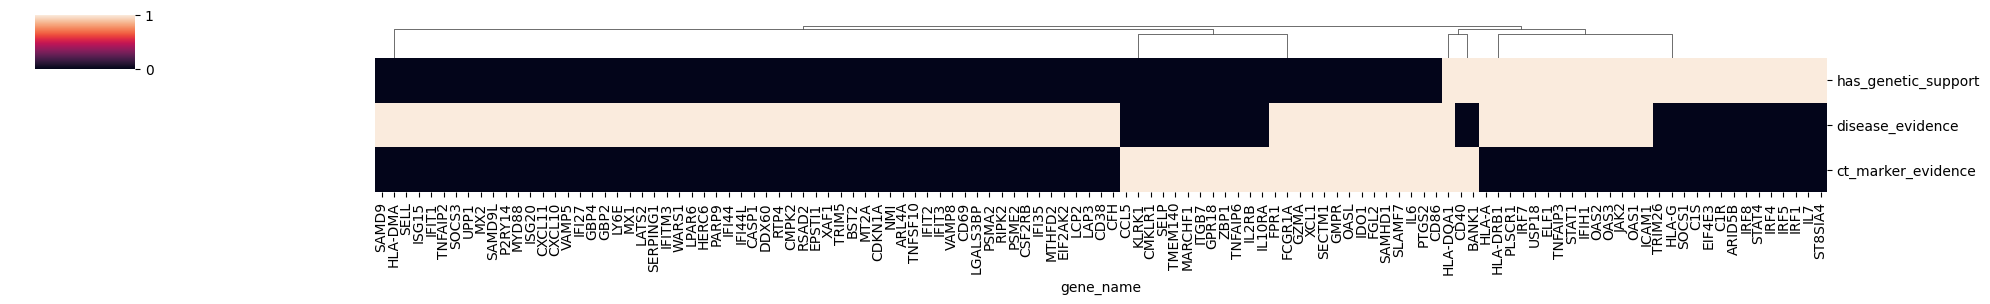

In [42]:
cl = sns.clustermap(
    ifn_genes_results[evidence_cols].T, row_cluster=False, xticklabels=True, figsize=(20,3));
ordered_genes = ifn_genes_results[evidence_cols].T.columns[cl.dendrogram_col.reordered_ind]

In [43]:
df = ifn_genes_results.reset_index().melt(id_vars=evidence_cols + ['gene_name'], var_name = 'category')
df = df.melt(id_vars = ['category', 'value', 'gene_name'], value_name='has_evidence', var_name='evidence')
df = df[df.value == 1]
df

category  value gene_name             evidence  has_evidence
0     receptors      1      CD38  has_genetic_support           0.0
1     receptors      1     PTGS2  has_genetic_support           0.0
4     receptors      1      JAK2  has_genetic_support           1.0
5     receptors      1     IL2RB  has_genetic_support           0.0
6     receptors      1      CD40  has_genetic_support           1.0
...         ...    ...       ...                  ...           ...
1394    targets      1      UPP1   ct_marker_evidence           0.0
1395    targets      1     SOCS3   ct_marker_evidence           0.0
1397    targets      1     IFIT1   ct_marker_evidence           0.0
1398    targets      1     ISG15   ct_marker_evidence           0.0
1400    targets      1   HLA-DMA   ct_marker_evidence           0.0

[228 rows x 5 columns]

In [49]:
%%R -i df -i ordered_genes -w 1300 -h 300
pl_df <- df %>%
arrange(evidence) %>%
mutate(gene_name=factor(gene_name, levels=ordered_genes)) %>%
mutate(category=factor(category, levels=(c('receptors', 'TFs', 'targets', 'secreted'))))


pl_df %>%
    ggplot(aes(gene_name,evidence, fill=as.factor(has_evidence))) +
    geom_tile() +
    facet_grid(.~category, scales='free', space='free') +
    scale_fill_manual(values=c('1'='black', "0"='white'))  +
    theme_classic(base_size=18) +
    xlab("IFN Gamma pathway supported genes\n(MSigDB Hallmark)") +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) 
    
ggsave_figdir('IFNg_targets_classes', width=18, height=4)
    

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


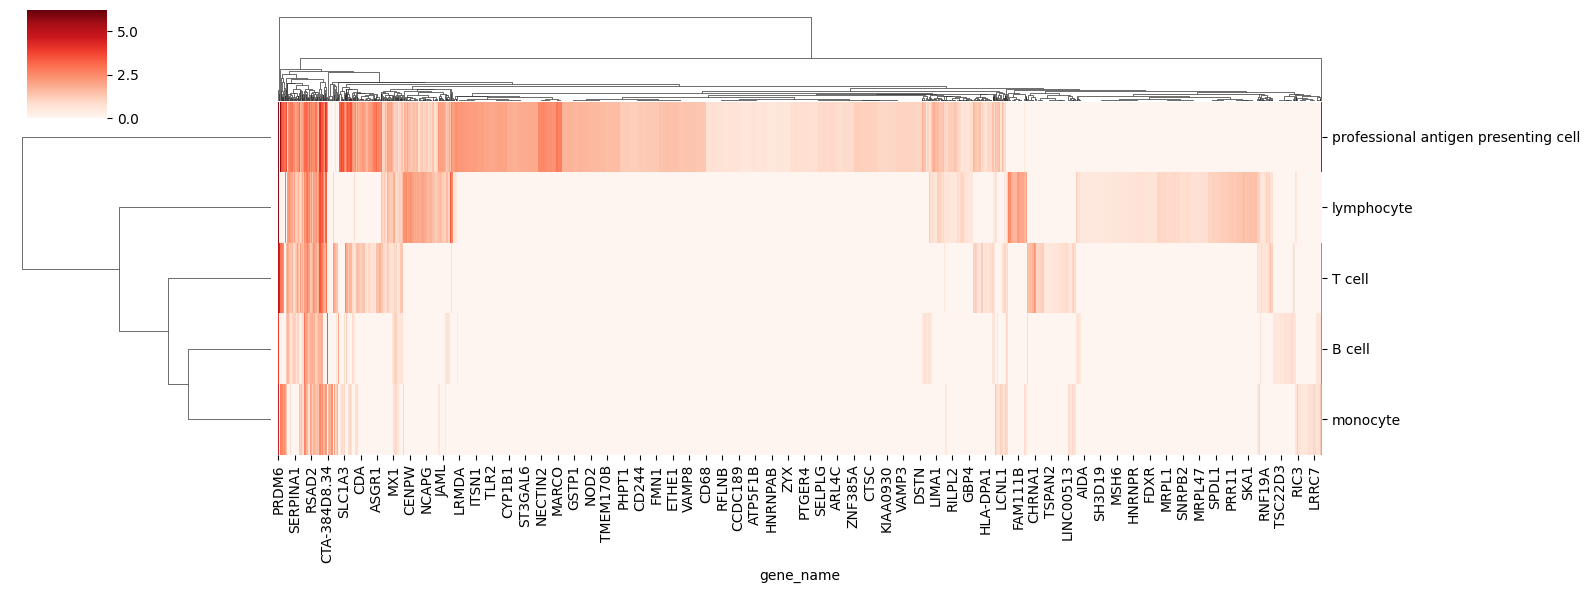

In [51]:
select_gene_ids = targets_res_coarse.gene_id[targets_res_coarse.is_safe==1]
hm_disease = get_evidence_celltypes(
#     DE_res_coarse[DE_res_coarse.gene_id.isin(select_gene_ids)],
        DE_res_coarse,
    targets_res_coarse, evidence='disease', clinical_status_cols=[])

hm_ct = get_evidence_celltypes(
    DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(select_gene_ids)], 
    targets_res_coarse, evidence='celltype')

# sns.clustermap(hm_disease[hm_disease.index.str.startswith("OAS")])
# plt.show()
sns.clustermap(hm_disease.T,  cmap='Reds', figsize=(16,6))

In [52]:
sc.pp.highly_variable_genes(pbulk_adata_coarse, layer='logcounts')
pbulk_adata_coarse.X = pbulk_adata_coarse.layers['logcounts'].copy()
sc.tl.pca(pbulk_adata_coarse,  use_highly_variable=True)

sc.tl.dendrogram(pbulk_adata_coarse, groupby='high_level_cell_type')

In [53]:
pbulk_adata_coarse.var_names = pbulk_adata_coarse.var.feature_name.values

In [ ]:
success_cols = ['is_safe','is_effective', 'is_approved']
cluster_clinical_status = True
evidence_cols = ['has_genetic_support', 'disease_evidence', 'ct_marker_evidence']

## -- Get info on explored targets -- ##
pl_df = targets_res_coarse[(targets_res_coarse['is_safe'] == 1) & (targets_res_coarse['has_genetic_support'] + targets_res_coarse['disease_evidence'] + targets_res_coarse['ct_marker_evidence'] > 0)][evidence_cols + success_cols + ['gene_name', 'gene_class']]
pl_df.loc[:,'gene_class'] = pl_df['gene_class'].astype('category').cat.set_categories(GENE_CLASS_ORDER)
row_order = pl_df.sort_values(['gene_class'] + evidence_cols).gene_name.unique().tolist() # Order by gene class

# Group targets by highest success
pl_df['success_group'] = np.where(
    (pl_df.is_safe == 1) & (pl_df.is_effective == 0), 'safe',
    np.where((pl_df.is_approved == 0) & (pl_df.is_effective == 1), 'effective', 'approved'))

targets_pl_df = pd.melt(pl_df, id_vars = ['gene_name', 'gene_class', 'success_group']).copy()
targets_pl_df['col_class'] = np.where(targets_pl_df['variable'].isin(evidence_cols), 'evidence', 'drug target\nclass')

## -- Get fraction of unexplored targets by class -- ##
pl_df = targets_res_coarse[targets_res_coarse['is_safe'] == 0][evidence_cols + success_cols + ['gene_name', 'gene_class']]
pl_df.loc[:,'gene_class'] = pl_df['gene_class'].astype('category').cat.set_categories(GENE_CLASS_ORDER)
pl_df = pd.melt(pl_df, id_vars = ['gene_name', 'gene_class'])
frac_pl_df = pl_df[pl_df.value == 1].groupby(['variable','gene_class']).sum().reset_index()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


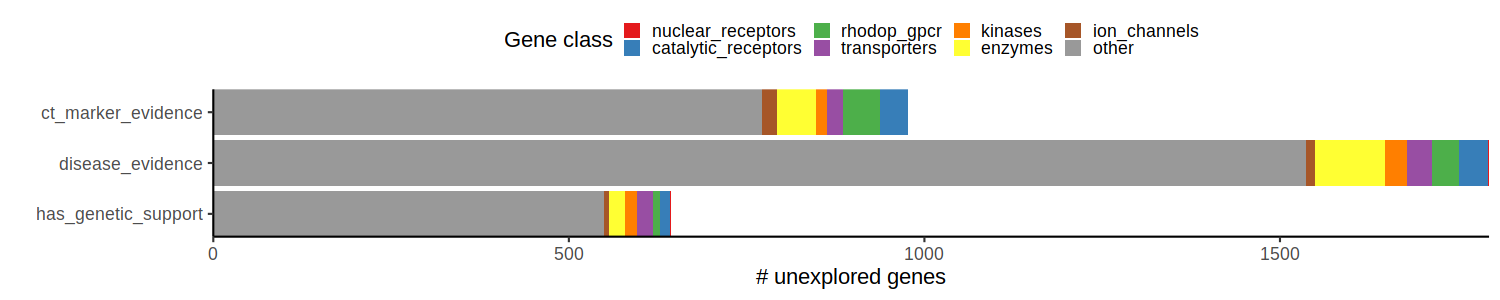

In [89]:
%%R -i targets_pl_df -i frac_pl_df -i evidence_cols -i row_order -w 1500 -h 300
# lapply(c('safe', 'effective', 'approved'), function(success_col){ 
pl1 <- targets_pl_df %>%
    filter(value == 1) %>%
    mutate(variable = factor(variable, levels=c(unlist(evidence_cols), 'is_approved', 'is_effective', 'is_safe'))) %>%
    arrange(variable) %>%
    mutate(gene_name=factor(gene_name, levels=row_order)) %>%
    ggplot(aes(gene_name, variable)) +
    geom_tile() +
    geom_tile(data=. %>% group_by(gene_name) %>% mutate(variable='target_class', col_class=''), aes(fill=gene_class)) +
    facet_grid(col_class~success_group, scales='free', space='free') +
    scale_fill_manual(values=gene_class_palette, name='Gene class') +
    theme_classic(base_size=22) +
    ylab('Cell type label') + xlab('Drug target gene') +
    guides(fill='none') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5, size=10), 
          strip.text.y = element_text(angle=0, hjust=0),
          strip.background = element_rect(fill = "transparent", color=NA),
           strip.placement = "outside",
            panel.border = element_rect(color = "black", fill = NA)) 

pl1 + ggsave('~/SLE_explored_targets.pdf',  width=15, height=5)
# + ggsave_figdir('SLE_explored_targets', width=25, height=5)

pl2 <- frac_pl_df %>%
    mutate(variable = factor(variable, levels=c('has_genetic_support', 'disease_evidence', 'ct_marker_evidence'))) %>%
    group_by(variable) %>%
    mutate(n = sum(value)) %>%
    ggplot(aes(variable, value)) +
#     geom_col(aes(fill=gene_class), position='fill') +
    geom_col(aes(fill=gene_class)) +
#     geom_text(data = . %>% distinct(n, variable),
#               aes(y=1.2, label=paste('n =', n)), size=6, hjust=1) +
    scale_fill_manual(values=gene_class_palette, name='Gene class') +
    theme_classic(base_size=22) +
    ylab('# unexplored genes') + xlab('') +
    coord_flip(expand=FALSE) +
    theme(legend.position='top')
pl2 + ggsave('~/SLE_fraction_unexplored.pdf',  width=10, height=3)
# pl2 + ggsave_figdir('SLE_fraction_unexplored', width=12, height=3)

In [ ]:
select_gene_ids = targets_res_coarse.gene_id[(targets_res_coarse['is_safe'] == 1) & (targets_res_coarse['has_genetic_support'] + targets_res_coarse['disease_evidence'] + targets_res_coarse['ct_marker_evidence'] > 0)]
hm_disease = get_evidence_celltypes(
    DE_res_coarse[DE_res_coarse.gene_id.isin(select_gene_ids)],
    targets_res_coarse, evidence='disease', clinical_status_cols=[])

hm_ct = get_evidence_celltypes(
    DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(select_gene_ids)], 
    targets_res_coarse, evidence='celltype')

# sns.clustermap(hm_disease[hm_disease.index.str.startswith("OAS")])
# plt.show()
sns.clustermap(hm_disease)
sns.clustermap(hm_ct)
# hm_disease

In [55]:
all_other_enr = pd.DataFrame()
evidence_cols = ['has_genetic_support', 'disease_evidence', 'ct_marker_evidence']

for ev in evidence_cols:
    other_enr = enrichment_analysis(
        targets_res_coarse, 
        filter_evidence = dict({(x,1) if x==ev else (x,0) for x in evidence_cols}), 
        filter_gene_class=['other'] + list(gene_class_palette.keys()),
#         filter_gene_class=['other'],
        fdr_alpha=1
    )
    other_enr['evidence'] = ev
    all_other_enr = pd.concat([all_other_enr, other_enr])


/tmp/ipykernel_868/2661780881.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_enr['evidence'] = ev
/tmp/ipykernel_868/2661780881.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_enr['evidence'] = ev
/tmp/ipykernel_868/2661780881.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [56]:
all_other_enr['top10_genes'] = [';'.join(x[0:10]) for x in all_other_enr['genes'].str.split(";")]
all_other_enr_signif = all_other_enr[all_other_enr['adj_pval'] < 0.05]
all_other_enr_signif = all_other_enr_signif[all_other_enr_signif['gene_set'] != 'MSigDB_Hallmark_2020']

In [60]:
%%R -i all_other_enr_signif -w 1900 -h 2300 
p1 <- all_other_enr_signif %>%
    filter(evidence == 'has_genetic_support') %>%
    arrange( - adj_pval) %>%
    mutate(term = factor(term, levels=term)) %>%
    ggplot(aes(-log10(adj_pval), term)) +
    geom_vline(xintercept=1, linetype=2, color='red') +
    geom_col(width=0.15, fill='black') +
    geom_point(size=5) +
    geom_text(aes(x=0, label=top10_genes), size=5, vjust=-1, hjust=0) +
#     xlim(0,25) +
    theme_classic(base_size=22) +
    facet_grid(gene_set~evidence, scales='free', space='free') +
    theme(strip.text.y = element_text(angle=0)) 
p2 <- all_other_enr_signif %>%
    filter(evidence == 'disease_evidence') %>%
    filter(adj_pval < 0.01) %>%
#     slice_min(adj_pval, n=10) %>%
    arrange( - adj_pval) %>%
    mutate(term = factor(term, levels=term)) %>%
    ggplot(aes(-log10(adj_pval), term)) +
    geom_vline(xintercept=1, linetype=2, color='red') +
    geom_col(width=0.15, fill='black') +
    geom_point(size=5) +
    geom_text(aes(x=0, label=top10_genes), size=5, vjust=-1, hjust=0) +
#     xlim(0,25) +
    theme_classic(base_size=22) +
    facet_grid(gene_set~evidence, scales='free', space='free') +
    theme(strip.text.y = element_text(angle=0)) 
p3 <- all_other_enr_signif %>%
    filter(evidence == 'ct_marker_evidence') %>%
#     slice_min(adj_pval, n=10) %>%
    arrange( - adj_pval) %>%
    mutate(term = factor(term, levels=term)) %>%
    ggplot(aes(-log10(adj_pval), term)) +
    geom_vline(xintercept=1, linetype=2, color='red') +
    geom_col(width=0.15, fill='black') +
    geom_point(size=5) +
    geom_text(aes(x=0, label=top10_genes), size=5, vjust=-1, hjust=0) +
#     xlim(0,25) +
    theme_classic(base_size=22) +
    facet_grid(gene_set~evidence, scales='free', space='free') +
    theme(strip.text.y = element_text(angle=0)) 
    
enr_plot <- (p1 / p2 / p3) +
    plot_layout(heights=c(0.5,2,2)) 
    
ggsave_figdir('SLE_enrichment_analysis', height=25, width=20)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


- Genetic evidence shows DNA binding genes
- Disease evidence: cell cycle, DNA replication, IFITM3 (used for prognosis https://www.cell.com/cell/fulltext/S0092-8674(16)30264-1?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867416302641%3Fshowall%3Dtrue)

Both associated to interferon response, but TFs for genetic evidence (IRF genes) and effectors (IFIT genes) for DE in disease evidence.

- Cell type evidence: complement, IG genes, chemokines, glomerular components - membrane and secreted proteins

### Chronic kidney disease

In [21]:
disease_ontology_id = 'MONDO_0005300'

In [22]:
pbulk_adata_coarse = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad', backed=True)
# pbulk_adata_coarse = _process_pbulk(pbulk_adata_coarse)
pbulk_adata_coarse[pbulk_adata_coarse.obs['disease'] != 'normal'].obs.donor_id.nunique()


19

In [23]:
gene_names_df = pbulk_adata_coarse.var[['feature_name', 'feature_id']].copy()
gene_names_df.columns = ['gene_name', 'gene_id']

In [24]:
## Read results with coarse annotations
targets_res_coarse = targets_evidence_all[targets_evidence_all.disease_ontology_id == disease_ontology_id]
targets_res_coarse = targets_res_coarse[targets_res_coarse.gene_id.isin(universe_dict['protein_coding_targets'])].copy()

DE_res_coarse = pd.read_csv(f'../data/DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')
DE_ct_res_coarse = pd.read_csv(f'../data/DE_celltype_{disease_ontology_id}.hvgs.csv')

In [25]:
success_cols = ['is_safe','is_effective', 'is_approved']
cluster_clinical_status = True
evidence_cols = ['has_genetic_support', 'disease_evidence', 'ct_marker_evidence']

## -- Get info on explored targets -- ##
pl_df = targets_res_coarse[targets_res_coarse['is_safe'] == 1][evidence_cols + success_cols + ['gene_name', 'gene_class']]
pl_df.loc[:,'gene_class'] = pl_df['gene_class'].astype('category').cat.set_categories(GENE_CLASS_ORDER)
row_order = pl_df.sort_values(['gene_class'] + evidence_cols).gene_name.unique().tolist() # Order by gene class

# Group targets by highest success
pl_df['success_group'] = np.where(
    (pl_df.is_safe == 1) & (pl_df.is_effective == 0), 'safe',
    np.where((pl_df.is_approved == 0) & (pl_df.is_effective == 1), 'effective', 'approved'))

targets_pl_df = pd.melt(pl_df, id_vars = ['gene_name', 'gene_class', 'success_group']).copy()
targets_pl_df['col_class'] = np.where(targets_pl_df['variable'].isin(evidence_cols), 'evidence', 'drug target\nclass')

## -- Get fraction of unexplored targets by class -- ##
pl_df = targets_res_coarse[targets_res_coarse['is_safe'] == 0][evidence_cols + success_cols + ['gene_name', 'gene_class']]
pl_df.loc[:,'gene_class'] = pl_df['gene_class'].astype('category').cat.set_categories(GENE_CLASS_ORDER)
pl_df = pd.melt(pl_df, id_vars = ['gene_name', 'gene_class'])
frac_pl_df = pl_df[pl_df.value == 1].groupby(['variable','gene_class']).sum().reset_index()

/tmp/ipykernel_5884/1740083542.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pl_df.loc[:,'gene_class'] = pl_df['gene_class'].astype('category').cat.set_categories(GENE_CLASS_ORDER)
/tmp/ipykernel_5884/1740083542.py:20: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pl_df.loc[:,'gene_class'] = pl_df['gene_class'].astype('category').cat.set_categories(GENE_CLASS_ORDER)
/tmp/ipykernel_5884/1740083542.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


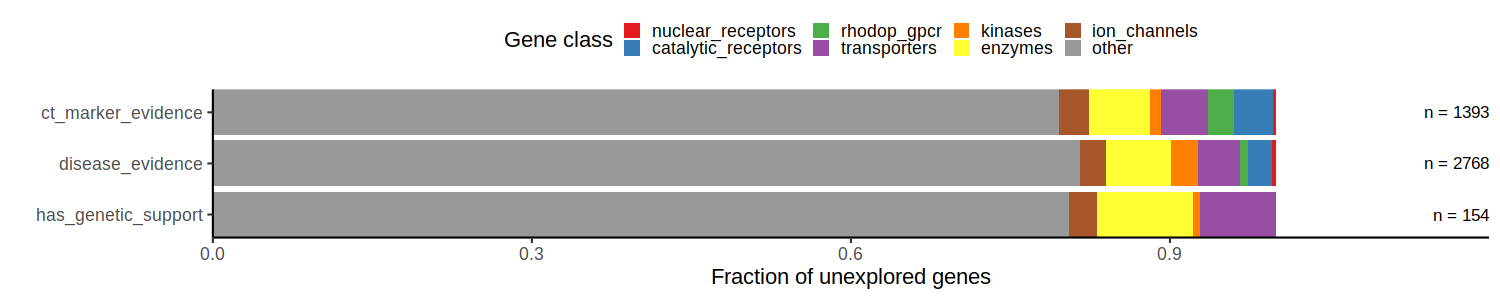

In [186]:
%%R -i targets_pl_df -i frac_pl_df -i evidence_cols -i row_order -w 1500 -h 300
# lapply(c('safe', 'effective', 'approved'), function(success_col){ 
pl1 <- targets_pl_df %>%
    mutate(value= ifelse(value==1, '1', NA)) %>%
    mutate(variable = factor(variable, levels=c(unlist(evidence_cols), 'is_approved', 'is_effective', 'is_safe'))) %>%
    arrange(variable) %>%
    mutate(gene_name=factor(gene_name, levels=row_order)) %>%
    ggplot(aes(gene_name, variable)) +
    geom_tile(aes(fill=value)) +
    geom_point(data=. %>% group_by(gene_name) %>% mutate(variable='target_class', col_class=''), aes(color=gene_class), 
               shape=15, size=3) +
    facet_grid(col_class~success_group, scales='free', space='free') +
    scale_color_manual(values=gene_class_palette, name='Gene class') +
    scale_fill_manual(values=c('black'), na.value="white") +
    theme_classic(base_size=22) +
    ylab('Cell type label') + xlab('Drug target gene') +
    guides(fill='none', color='none') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5, size=10), 
          strip.text.y = element_text(angle=0, hjust=0),
          strip.background = element_rect(fill = "transparent", color=NA),
           strip.placement = "outside",
            panel.border = element_rect(color = "black", fill = NA)) 

pl1 + ggsave_figdir('CKD_explored_targets', width=27, height=5)

pl2 <- frac_pl_df %>%
    mutate(variable = factor(variable, levels=c('has_genetic_support', 'disease_evidence', 'ct_marker_evidence'))) %>%
    group_by(variable) %>%
    mutate(n = sum(value)) %>%
    ggplot(aes(variable, value)) +
    geom_col(aes(fill=gene_class), position='fill') +
    geom_text(data = . %>% distinct(n, variable),
              aes(y=1.2, label=paste('n =', n)), size=6, hjust=1) +
    scale_fill_manual(values=gene_class_palette, name='Gene class') +
    theme_classic(base_size=22) +
    ylab('Fraction of unexplored genes') + xlab('') +
    coord_flip(expand=FALSE) +
    theme(legend.position='top')

pl2 + ggsave_figdir('CKD_fraction_unexplored', width=12, height=3)

{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: xlabel='Intersection size'>}

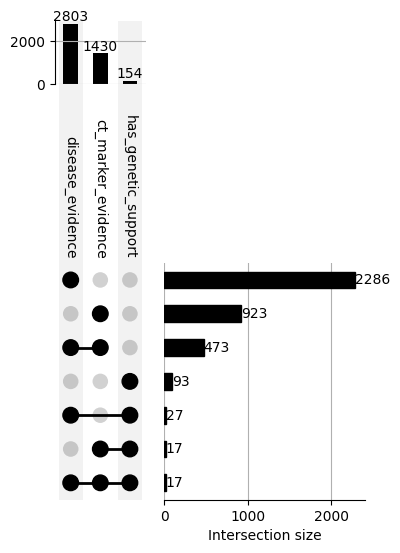

In [121]:
targets_res_coarse['target_disease'] = targets_res_coarse['gene_id'] + "_" + targets_res_coarse['disease_ontology_id']
evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']
evidence_sets_dict = {}
for ev in evidence_cols:
    evidence_sets_dict[ev] = targets_res_coarse.target_disease[
        (targets_res_coarse[ev] == 1)
    ].tolist()

evidence_upset = upsetplot.from_contents(evidence_sets_dict)

pl = upsetplot.UpSet(
    evidence_upset, 
    orientation='vertical', 
    show_counts = '{:d}', 
    sort_categories_by='cardinality',
    sort_by='cardinality', 
)
pl.plot()

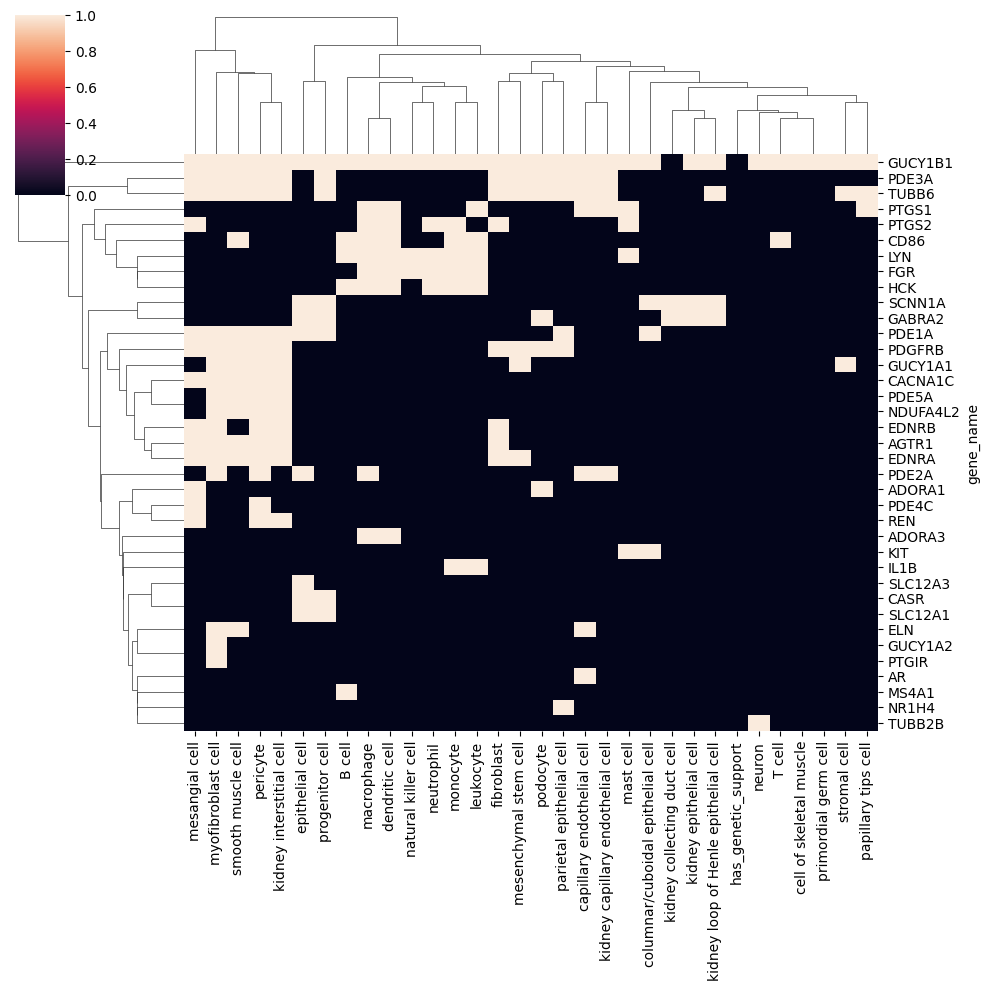

In [114]:
select_gene_ids = targets_res_coarse.gene_id[targets_res_coarse.is_safe == 1]
hm_disease = get_evidence_celltypes(
    DE_res_coarse[DE_res_coarse.gene_id.isin(select_gene_ids)],
    targets_res_coarse, evidence='disease', clinical_status_cols=['has_genetic_support'])

hm_ct = get_evidence_celltypes(
    DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(select_gene_ids)], 
    targets_res_coarse, evidence='celltype', clinical_status_cols=['has_genetic_support'])

# sns.clustermap(hm_disease[hm_disease.index.str.startswith("OAS")])
plt.show()
sns.clustermap(hm_ct)

In [26]:
pbulk_adata_coarse = pbulk_adata_coarse.to_memory()

In [27]:
_process_pbulk(pbulk_adata_coarse)

AnnData object with n_obs × n_vars = 879 × 19907
    obs: 'high_level_cell_type_ontology_term_id', 'assay', 'suspension_type', 'disease', 'donor_id', 'size_factors', 'n_cells', 'disease_name_original', 'high_level_cell_type', 'sample_id', 'disease_ontology_id', 'plot_ct_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean_logcounts'
    layers: 'logcounts'

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


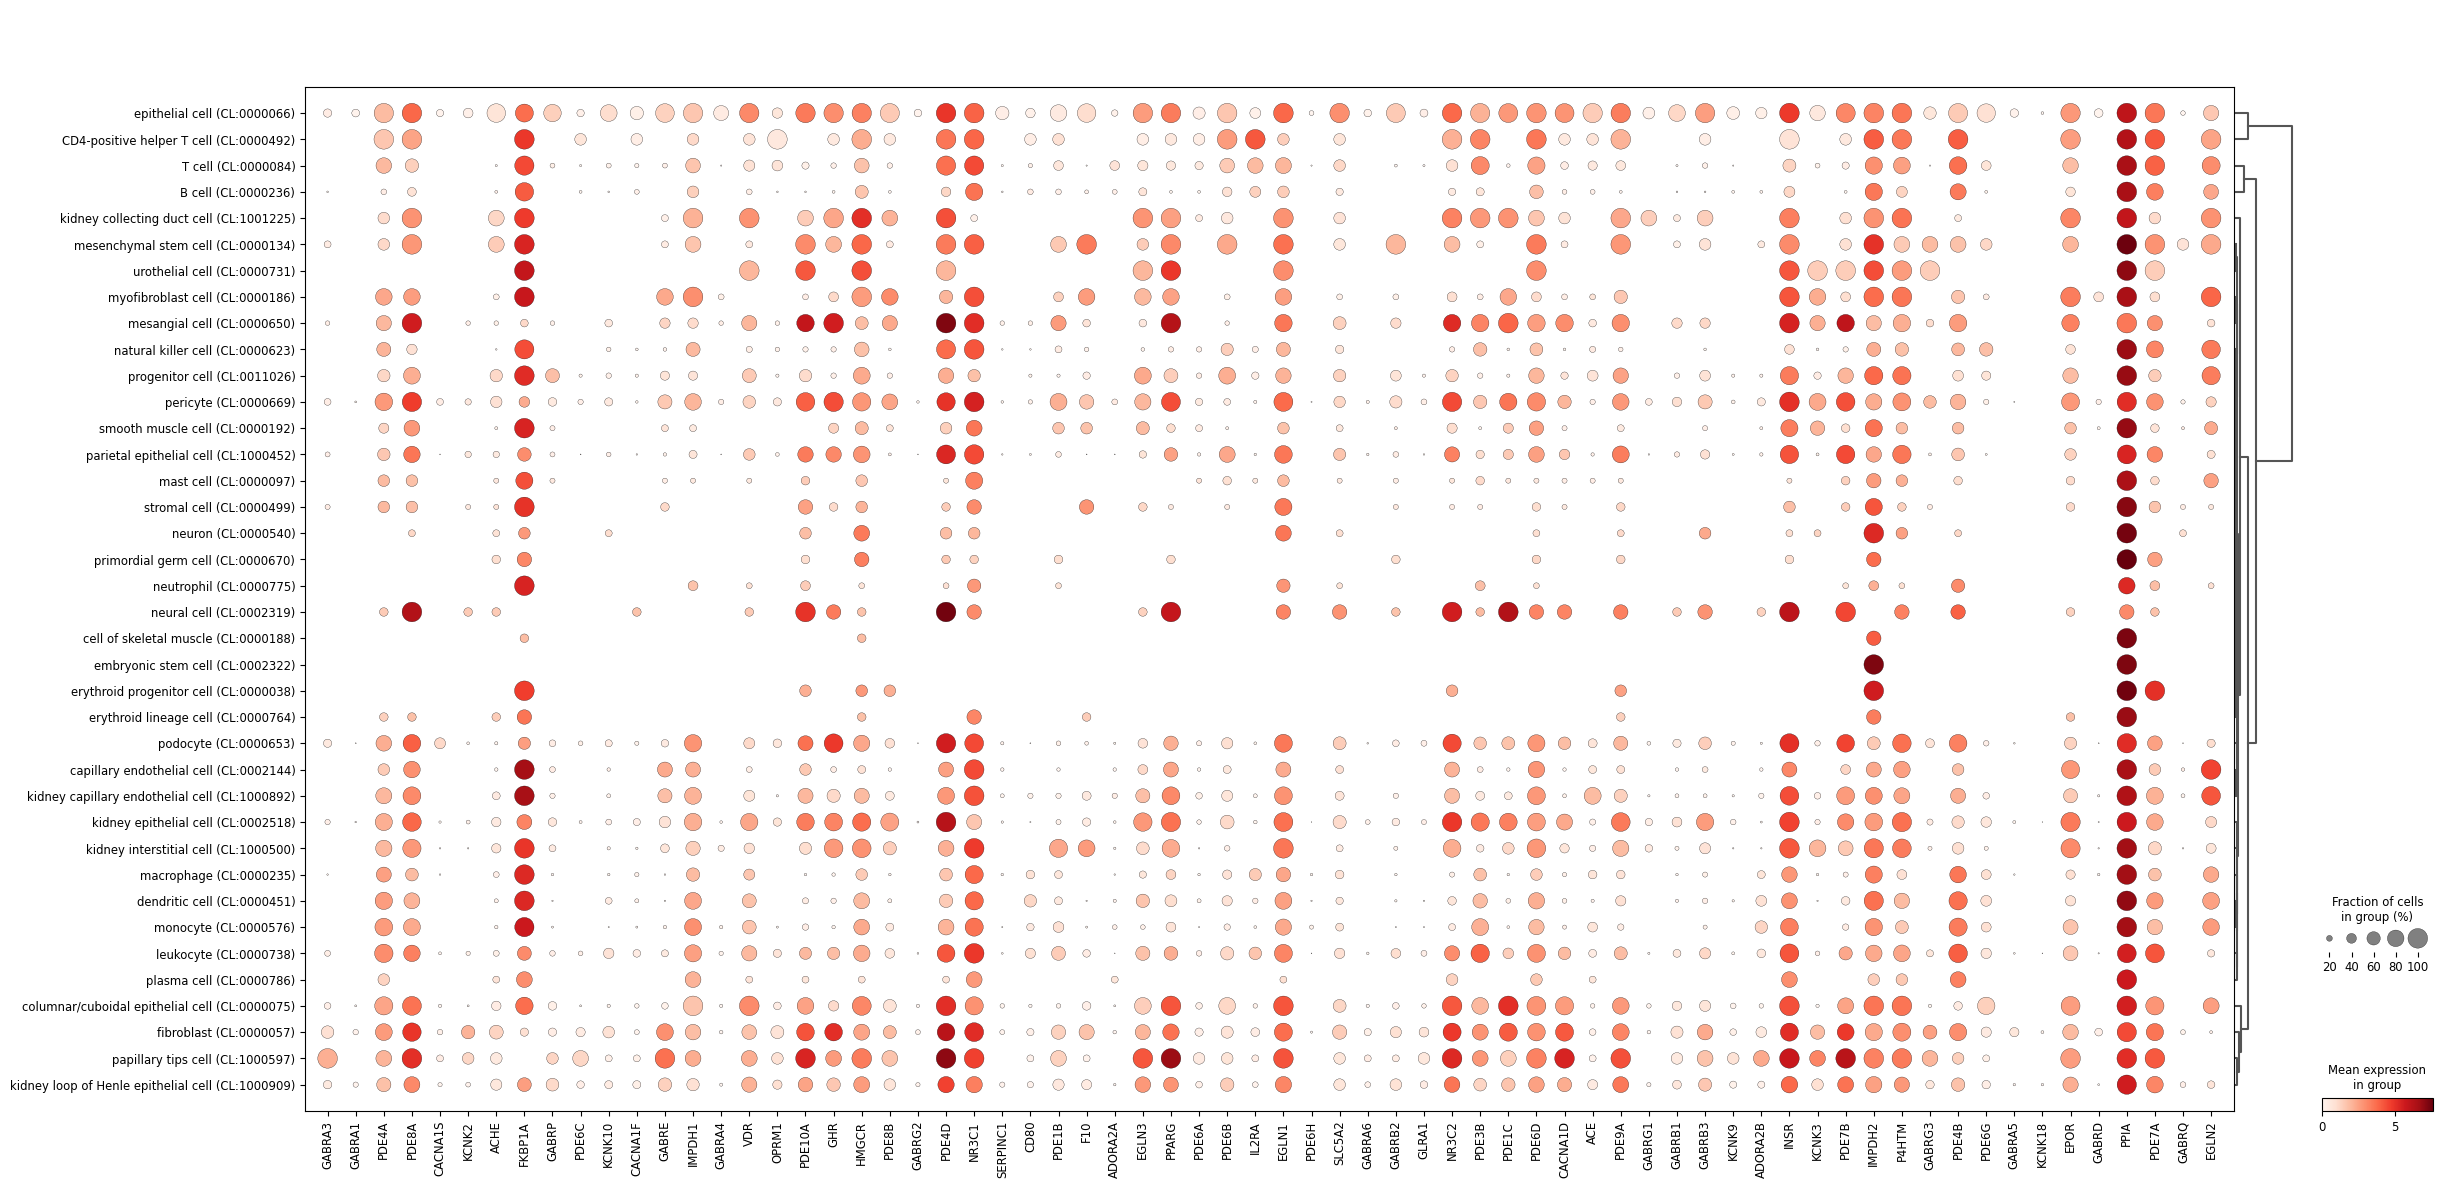

In [49]:
gs = targets_res_coarse.gene_name[(targets_res_coarse.is_approved == 1) & (targets_res_coarse.ct_marker_evidence != 1)].unique()
sc.pl.dotplot(pbulk_adata_coarse, gs, groupby='high_level_cell_type', gene_symbols='feature_name', layer='logcounts', dendrogram=True);

In [125]:
n_pbulks = pbulk_adata_coarse.obs.groupby('high_level_cell_type').count()['assay']
n_cells = pbulk_adata_coarse.obs.groupby('high_level_cell_type').sum('n_cells')['n_cells']
plot_cts = n_pbulks.index[(n_pbulks > 5) & (n_cells > 100)].to_list()
pl_adata = pbulk_adata_coarse[pbulk_adata_coarse.obs['high_level_cell_type'].isin(plot_cts)].copy()


In [135]:
order_cts = ['epithelial cell (CL:0000066)',
 'kidney collecting duct cell (CL:1001225)',
 'columnar/cuboidal epithelial cell (CL:0000075)',
 'parietal epithelial cell (CL:1000452)',
 'kidney loop of Henle epithelial cell (CL:1000909)',
 'kidney epithelial cell (CL:0002518)',
 'kidney interstitial cell (CL:1000500)',
 'papillary tips cell (CL:1000597)',
 'stromal cell (CL:0000499)',
    'mesangial cell (CL:0000650)',
    'smooth muscle cell (CL:0000192)',
 'pericyte (CL:0000669)',
 'podocyte (CL:0000653)',
              'capillary endothelial cell (CL:0002144)',
 'kidney capillary endothelial cell (CL:1000892)',
 'myofibroblast cell (CL:0000186)',
    'fibroblast (CL:0000057)',

 'primordial germ cell (CL:0000670)',
              'progenitor cell (CL:0011026)',
 'mesenchymal stem cell (CL:0000134)',
 'macrophage (CL:0000235)',
    'monocyte (CL:0000576)',
 'mast cell (CL:0000097)',
              'dendritic cell (CL:0000451)',
              'natural killer cell (CL:0000623)',
 'T cell (CL:0000084)',
 'CD4-positive helper T cell (CL:0000492)',
              'B cell (CL:0000236)',
 'leukocyte (CL:0000738)',
 'plasma cell (CL:0000786)',
]

order_cts = pd.Series(order_cts)[pd.Series(order_cts).isin(pl_adata.obs['high_level_cell_type'].unique())].tolist()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


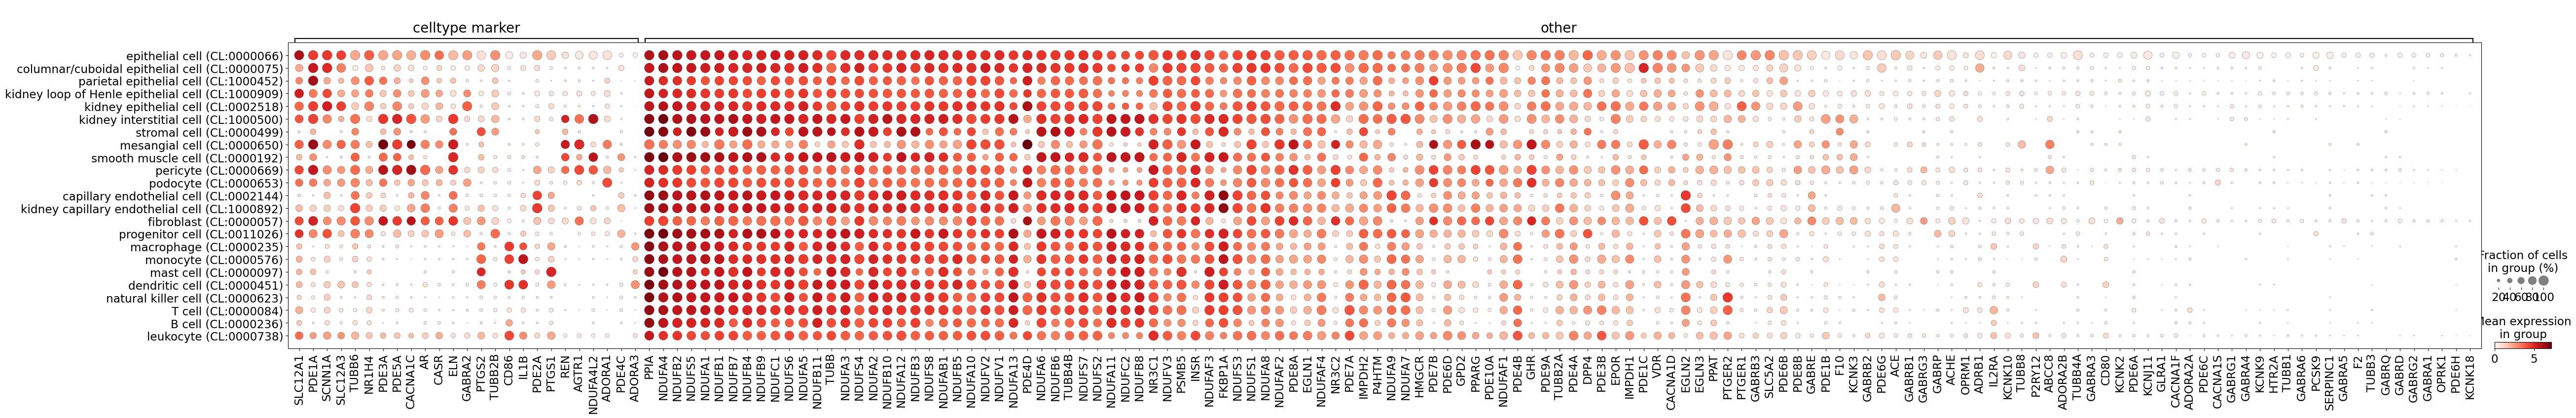

In [136]:
gs_markers = targets_res_coarse.gene_name[(targets_res_coarse.is_effective == 1) & (targets_res_coarse.ct_marker_evidence == 1)].unique()
gs_other = targets_res_coarse.gene_name[(targets_res_coarse.is_effective == 1) & (targets_res_coarse.ct_marker_evidence != 1)].unique()

# reorder by mean expression
gs_markers = pbulk_adata_coarse.var.set_index('feature_name').loc[gs_markers, 'mean_logcounts'].sort_values(ascending=False).index
gs_other = pbulk_adata_coarse.var.set_index('feature_name').loc[gs_other, 'mean_logcounts'].sort_values(ascending=False).index

with plt.rc_context({'font.size':20}):
    sc.pl.dotplot(pl_adata, 
                  {'celltype marker':gs_markers, 'other':gs_other}, 
                  groupby='high_level_cell_type', gene_symbols='feature_name', layer='logcounts', 
                  var_group_rotation=0,
                  categories_order=order_cts);

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


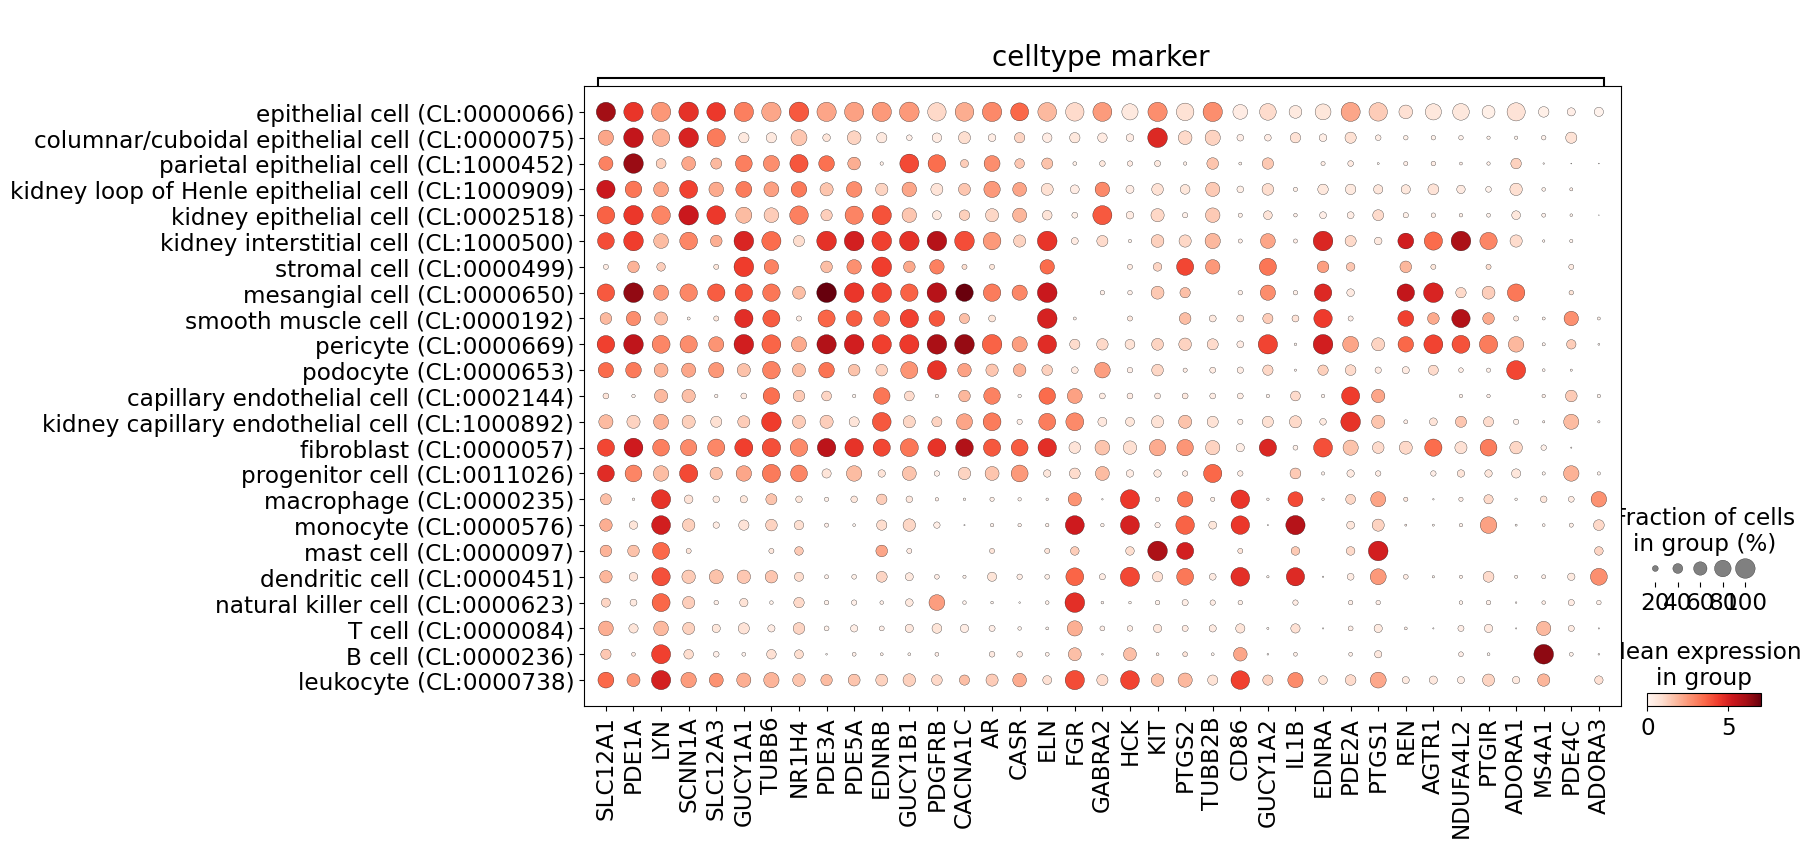

In [137]:
gs_markers = targets_res_coarse.gene_name[(targets_res_coarse.is_safe == 1) & (targets_res_coarse.ct_marker_evidence == 1)].unique()

# reorder by mean expression
gs_markers = pbulk_adata_coarse.var.set_index('feature_name').loc[gs_markers, 'mean_logcounts'].sort_values(ascending=False).index

with plt.rc_context({'font.size':20}):
    sc.pl.dotplot(pl_adata, 
                  {'celltype marker':gs_markers}, 
                  groupby='high_level_cell_type', gene_symbols='feature_name', layer='logcounts', 
                  var_group_rotation=0,
                  categories_order=order_cts);

In [116]:
enr_genetics = enrichment_analysis(
        targets_res_coarse, 
        filter_evidence = dict({(x,1) if x=='has_genetic_support' else (x,0) for x in evidence_cols}), 
        filter_gene_class=GENE_CLASS_ORDER,
        fdr_alpha=1
    )

In [119]:
enr_genetics.sort_values('adj_pval')[0:30]

gene_set  \
24   GO_Biological_Process_2017   
0          MSigDB_Hallmark_2020   
424  GO_Cellular_Component_2017   
1          MSigDB_Hallmark_2020   
2          MSigDB_Hallmark_2020   
425  GO_Cellular_Component_2017   
25   GO_Biological_Process_2017   
426  GO_Cellular_Component_2017   
427  GO_Cellular_Component_2017   
428  GO_Cellular_Component_2017   
430  GO_Cellular_Component_2017   
429  GO_Cellular_Component_2017   
431  GO_Cellular_Component_2017   
433  GO_Cellular_Component_2017   
432  GO_Cellular_Component_2017   
435  GO_Cellular_Component_2017   
436  GO_Cellular_Component_2017   
434  GO_Cellular_Component_2017   
437  GO_Cellular_Component_2017   
440  GO_Cellular_Component_2017   
438  GO_Cellular_Component_2017   
439  GO_Cellular_Component_2017   
350  GO_Molecular_Function_2017   
351  GO_Molecular_Function_2017   
324  GO_Molecular_Function_2017   
328  GO_Molecular_Function_2017   
349  GO_Molecular_Function_2017   
327  GO_Molecular_Function_2017   
348  GO_Molecular_Function_2017   
347  GO_Molecular_Function_2017   

                                                  term      pval  adj_pval  \
24    regulation of complement activation (GO:0030449)  0.000084  0.025085   
0                               Estrogen Response Late  0.001050  0.025191   
424           basolateral plasma membrane (GO:0016323)  0.000663  0.050375   
1                                      Mitotic Spindle  0.005550  0.054887   
2                                 Bile Acid Metabolism  0.006861  0.054887   
425                   blood microparticle (GO:0072562)  0.001471  0.055889   
25   positive regulation of transcription from RNA ...  0.000538  0.079958   
426  RNA polymerase II transcription factor complex...  0.003549  0.080405   
427  integral component of plasma membrane (GO:0005...  0.004996  0.080405   
428                         motile cilium (GO:0031514)  0.005290  0.080405   
430                   cytoplasmic vesicle (GO:0031410)  0.007876  0.085506   
429               secretory granule lumen (GO:0034774)  0.007614  0.085506   
431                            centrosome (GO:0005813)  0.012439  0.086985   
433           endoplasmic reticulum lumen (GO:0005788)  0.013460  0.086985   
432                apical plasma membrane (GO:0016324)  0.013144  0.086985   
435                        sperm midpiece (GO:0097225)  0.014879  0.086985   
436          tRNA-splicing ligase complex (GO:0072669)  0.014879  0.086985   
434                             nucleolus (GO:0005730)  0.014090  0.086985   
437                        early endosome (GO:0005769)  0.016175  0.087807   
440                    actin cytoskeleton (GO:0015629)  0.020473  0.091527   
438  cyclin-dependent protein kinase activating kin...  0.019790  0.091527   
439               membrane attack complex (GO:0005579)  0.019790  0.091527   
350     aryl hydrocarbon receptor binding (GO:0017162)  0.029541  0.098151   
351                 RNA helicase activity (GO:0003724)  0.029541  0.098151   
324  core promoter sequence-specific DNA binding (G...  0.007911  0.098151   
328                       mannose binding (GO:0005537)  0.014879  0.098151   
349       sugar:proton symporter activity (GO:0005351)  0.029541  0.098151   
327  peroxisome proliferator activated receptor bin...  0.014879  0.098151   
348       glucocorticoid receptor binding (GO:0035259)  0.029541  0.098151   
347   chloride channel regulator activity (GO:0017081)  0.029541  0.098151   

                                                 genes  
24                                 CD81;CFHR1;C9;CFHR5  
0                         SLC9A3R1;TH;NRIP1;ETFB;ANXA9  
424                               CD81;KCNQ1;AQP4;PKD1  
1                             ANLN;ARHGDIA;ALMS1;ACTN4  
2                                  IDI1;SLC22A18;APOA1  
425                               CFHR1;C9;APOA1;APOL1  
25     ASXL1;BCAS3;TFDP2;KAT5;CD81;SP3;NRIP1;TET2;PKD1  
426                                         ARNT;ASCL2  
427  

In [141]:
all_other_enr = pd.DataFrame()
evidence_cols = ['has_genetic_support', 'disease_evidence', 'ct_marker_evidence']

for ev in evidence_cols:
    other_enr = enrichment_analysis(
        targets_res_coarse, 
        filter_evidence = dict({(x,1) if x==ev else (x,0) for x in evidence_cols}), 
        filter_gene_class=GENE_CLASS_ORDER,
        fdr_alpha=1
    )
    other_enr['evidence'] = ev
    all_other_enr = pd.concat([all_other_enr, other_enr])


other_enr = enrichment_analysis(
        targets_res_coarse, 
        filter_evidence = dict({(x,1) if x != 'has_genetic_evidence' else (x,0)for x in evidence_cols}), 
        filter_gene_class=['other'],
        fdr_alpha=1
    )
other_enr['evidence'] = 'genetics AND disease'
all_other_enr = pd.concat([all_other_enr, other_enr])

/tmp/ipykernel_5884/1060947099.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_enr['evidence'] = ev
/tmp/ipykernel_5884/1060947099.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_enr['evidence'] = ev
/tmp/ipykernel_5884/1060947099.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [144]:
all_other_enr['top10_genes'] = [';'.join(x[0:10]) for x in all_other_enr['genes'].str.split(";")]
all_other_enr_signif = all_other_enr[all_other_enr['adj_pval'] < 0.05]

# gen_enr = all_other_enr[all_other_enr.evidence == 'has_genetic_support'].copy()
# np.unique(sum(gen_enr['genes'].str.split(";", expand=False).values, []))

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


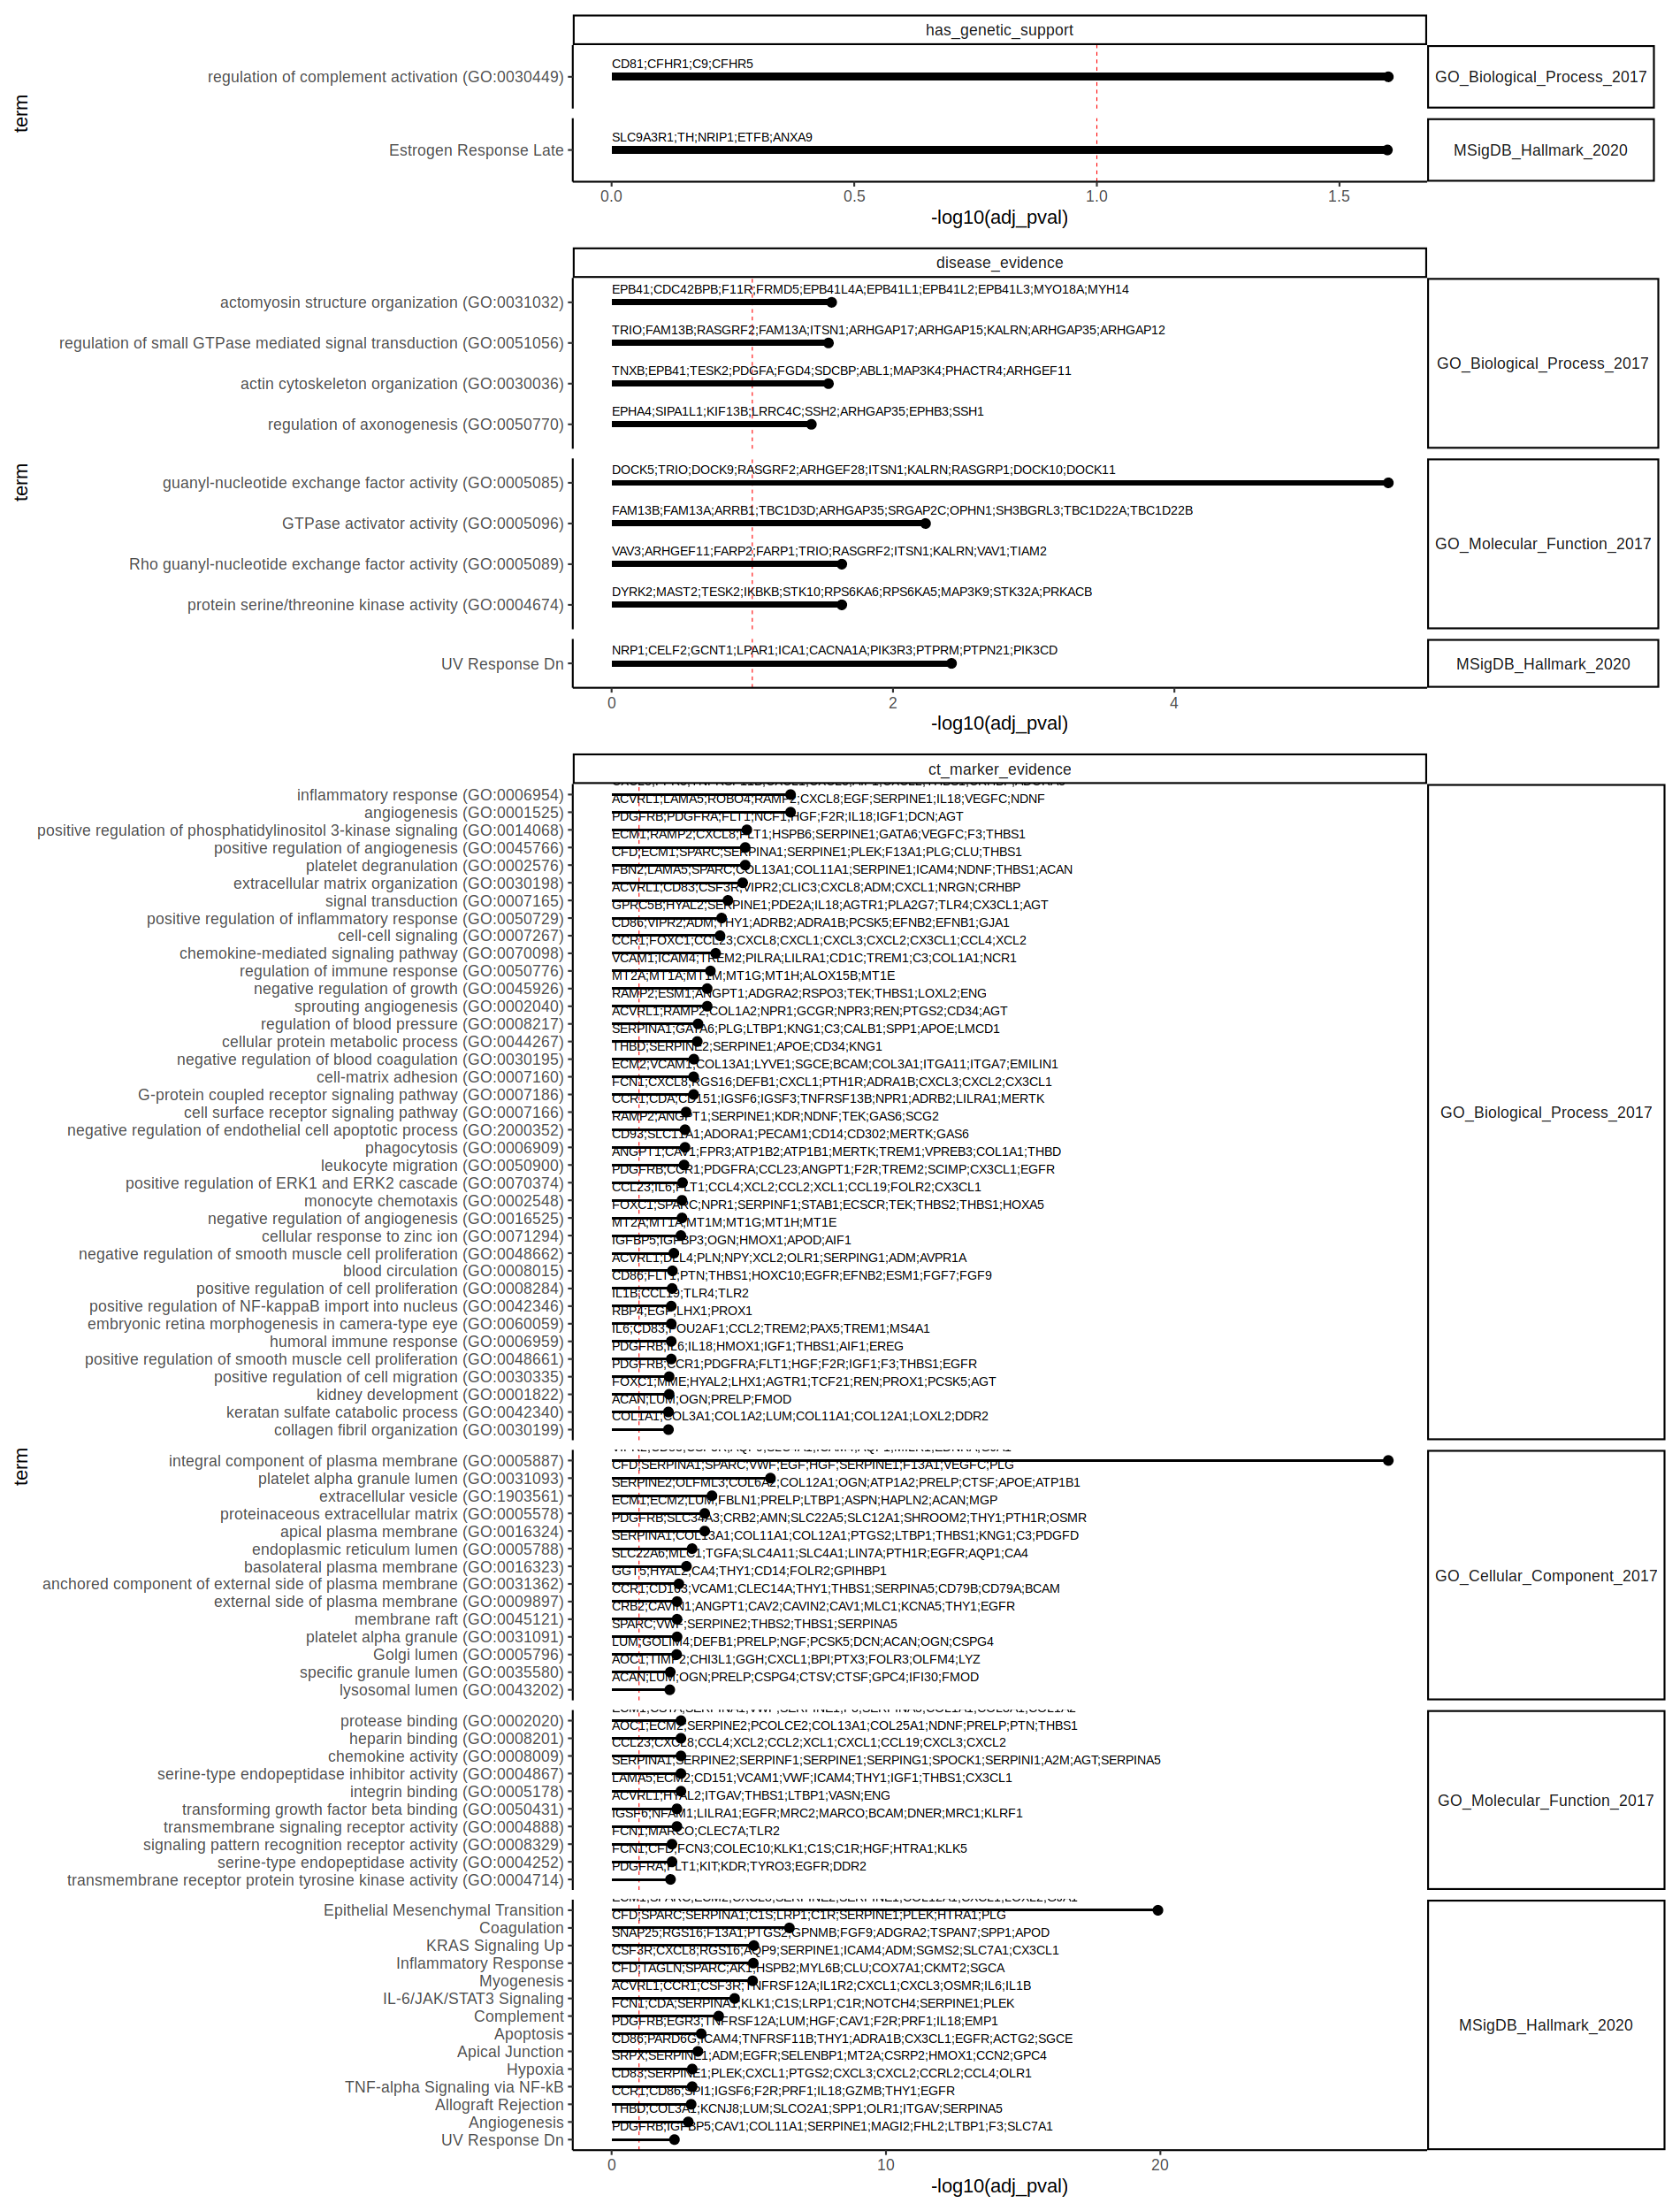

In [161]:
%%R -i all_other_enr_signif -w 1900 -h 2500 
p1 <- all_other_enr_signif %>%
    filter(evidence == 'has_genetic_support') %>%
    arrange( - adj_pval) %>%
    mutate(term = factor(term, levels=term)) %>%
    ggplot(aes(-log10(adj_pval), term)) +
    geom_vline(xintercept=1, linetype=2, color='red') +
    geom_col(width=0.15, fill='black') +
    geom_point(size=5) +
    geom_text(aes(x=0, label=top10_genes), size=5, vjust=-1, hjust=0) +
#     xlim(0,25) +
    theme_classic(base_size=22) +
    facet_grid(gene_set~evidence, scales='free', space='free') +
    theme(strip.text.y = element_text(angle=0)) 
p2 <- all_other_enr_signif %>%
    filter(evidence == 'disease_evidence') %>%
#     filter(adj_pval < 0.01) %>%
#     slice_min(adj_pval, n=10) %>%
    arrange( - adj_pval) %>%
    mutate(term = factor(term, levels=term)) %>%
    ggplot(aes(-log10(adj_pval), term)) +
    geom_vline(xintercept=1, linetype=2, color='red') +
    geom_col(width=0.15, fill='black') +
    geom_point(size=5) +
    geom_text(aes(x=0, label=top10_genes), size=5, vjust=-1, hjust=0) +
#     xlim(0,25) +
    theme_classic(base_size=22) +
    facet_grid(gene_set~evidence, scales='free', space='free') +
    theme(strip.text.y = element_text(angle=0)) 
p3 <- all_other_enr_signif %>%
    filter(evidence == 'ct_marker_evidence') %>%
#     slice_min(adj_pval, n=10) %>%
    filter(adj_pval < 0.01) %>%
    arrange( - adj_pval) %>%
    mutate(term = factor(term, levels=term)) %>%
    ggplot(aes(-log10(adj_pval), term)) +
    geom_vline(xintercept=1, linetype=2, color='red') +
    geom_col(width=0.15, fill='black') +
    geom_point(size=5) +
    geom_text(aes(x=0, label=top10_genes), size=5, vjust=-1, hjust=0) +
#     xlim(0,25) +
    theme_classic(base_size=22) +
    facet_grid(gene_set~evidence, scales='free', space='free') +
    theme(strip.text.y = element_text(angle=0)) 
    
(p1 / p2 / p3) +
plot_layout(heights=c(0.2,0.6,2))

### Fraction plots

In [ ]:
n_x_disease = targets_evidence_all.groupby('disease_ontology_id').sum()
# test_diseases = n_x_disease.index[(n_x_disease['has_genetic_support'] > 0) & (n_x_disease['is_approved'] > 0)]

pl_df = targets_evidence_all.groupby(['disease_ontology_id','gene_class']).sum()[['disease_evidence', 'ct_marker_evidence', 'is_approved', 'is_effective', 'is_safe', 'has_genetic_support']]
pl_df = pl_df.reset_index().melt(['disease_ontology_id','gene_class'], var_name='evidence', value_name='n_targets')
# pl_df = pl_df[pl_df.disease_ontology_id.isin(test_diseases)].copy()
pl_df['disease'] = [disease_name_mapper[x] for x in pl_df.disease_ontology_id.str.replace('_',':')]
pl_df['group'] = np.where(pl_df.evidence.isin(evidence_cols), 'support', 'success')

disease_order = targets_evidence_all[['disease', 'disease_relevant_tissue']].drop_duplicates().sort_values('disease_relevant_tissue')['disease']

In [ ]:
%%R -i pl_df -i disease_order -w 1000 -h 3000
df <- pl_df %>%
    mutate(gene_class= factor(gene_class, levels=c('catalytic_receptors', 'enzymes', 'ion_channels', 'kinases',
           'nuclear_receptors', 'rhodop_gpcr', 'transporters', 'other'))) %>%
    mutate(disease = factor(disease, levels=as.list(disease_order)))
    
pl2 <- df %>%
    mutate(gene_class= factor(gene_class, levels=c('catalytic_receptors', 'enzymes', 'ion_channels', 'kinases',
           'nuclear_receptors', 'rhodop_gpcr', 'transporters', 'other'))) %>%
    ggplot(aes(evidence, n_targets, fill=gene_class)) +
    geom_col(position='fill', width=0.7) +
    coord_flip() +
    scale_fill_manual(values=gene_class_palette, name='Gene class') +
    facet_grid(disease~.) +
    xlab('Fraction of genes') +
    theme_classic(base_size=18) +
    theme(
        strip.text.y = element_blank(), 
        legend.position='top',
        strip.background = element_blank())

pl1 <- df %>%
    group_by(disease, group, evidence) %>%
    summarise(n_targets=sum(n_targets)) %>%
    ggplot(aes(evidence, log10(n_targets+1), fill=group)) +
    geom_col(width=0.7) +
    geom_text(aes(label=n_targets), size=5, hjust=-0.05) +
    coord_flip() +
    scale_fill_manual(values=c(support='black', success='#006633')) +
    guides(fill='none') +
    ylim(0,5) +
    ylab('# genes') +
    scale_y_continuous(breaks=seq(0,4), label=c(0,10,100,1000,10000)) +
    facet_grid(disease~.) +
    theme_classic(base_size=18) +
    remove_y_axis() +
    theme(
        strip.text.y = element_text(angle=0), 
        axis.line.y = element_blank(),
        strip.background = element_rect(color=NA, fill='grey'))
    
(pl2 + plot_spacer() + pl1 ) +
    plot_layout(guides='collect', widths=c(1,-0.1, 0.7)) & (theme(legend.position='top')) 

ggsave_figdir('targets_barplots_all', width=12, height=40)

In [ ]:
%%R -i pl_df -i disease_order -w 1000 -h 1000
df %>%
    group_by(disease, group, evidence) %>%
    filter(evidence != 'has_genetic_support') %>%
    mutate(tot_targets=sum(n_targets)) %>%
    mutate(gene_class= factor(gene_class, levels=c('catalytic_receptors', 'enzymes', 'ion_channels', 'kinases',
           'nuclear_receptors', 'rhodop_gpcr', 'transporters', 'other'))) %>%
    filter(gene_class!='other' & group == 'support') %>%
    ggplot(aes(disease, n_targets/tot_targets, fill=gene_class)) +
    geom_col(position='stack', width=0.7) +
    coord_flip() +
    scale_fill_manual(values=gene_class_palette, name='Gene class') +
    facet_grid(evidence~.) +
    xlab('Fraction of genes') +
    theme_classic(base_size=18) +
    theme(
        legend.position='top',
        strip.background = element_blank())

In [ ]:
success_cols = ['is_effective', 'is_approved', 'has_genetic_support']
cluster_clinical_status = False

keep_targets = targets_res_coarse[targets_res_coarse['is_approved'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='celltype'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_ct.index)
for t in missing_genes:
    df_ct.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_ct.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

df_dis = get_evidence_celltypes(DE_res_coarse[DE_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='disease'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_dis.index)
for t in missing_genes:
    df_dis.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_dis.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

# Get the row orders
cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
cluster = sns.clustermap(cl_df, metric='jaccard', col_cluster=False)
row_order = cl_df.index[cluster.dendrogram_row.reordered_ind]

df_ct = df_ct.reset_index().melt( ['gene_name'] , var_name='celltype')
df_ct['evidence'] = 'celltype_marker'        
df_dis = df_dis.reset_index().melt( ['gene_name'] , var_name='celltype')
df_dis['evidence'] = 'disease'

pl_df = pd.concat([df_dis, df_ct])
pl_df['evidence'] = np.where(pl_df.celltype.isin(success_cols), 'clinical status', pl_df['evidence'])
pl_df['evidence'] = np.where(pl_df.celltype == ('has_genetic_support'), 'genetic support', pl_df['evidence'])

if cluster_clinical_status:
    pl_df['target_success'] = 'is_effective'
    for c in success_cols:
        print(c)
        pl_df['target_success'] = np.where(pl_df.gene_name.isin(pl_df.gene_name[(pl_df.celltype == c) & (pl_df.value == 1)]), c, pl_df['target_success'])
else:
    pl_df['target_success'] = 'targets'

    
pl_df['target_class'] = [reversed_annos[x] if x in reversed_annos.keys() else np.nan for x in pl_df.gene_name]

target_df = pl_df[['gene_name', 'target_class']].drop_duplicates()
target_df.columns = ['gene_name', 'value']
target_df['celltype'] = 'target_class'
target_df['evidence'] = 'target_class'
pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)

pl_df.loc[pl_df.value == 1, 'value'] = 'yes'
pl_df = pl_df[pl_df.value != 0].copy()

In [ ]:
ct_order_coarse = pl_df.celltype[pl_df['evidence'].isin(['celltype_marker', 'disease'])].unique()

In [ ]:
%%R -i pl_df -i ct_order_coarse -i row_order -i success_cols 
head(pl_df)

In [ ]:
%%R -w 1300 -h 600
pl_df %>%
    filter(celltype != 'malignant cell') %>%
    mutate(evidence = factor(evidence, levels=c('clinical status','celltype_marker', 'disease','genetic support',  'target_class'))) %>%
    mutate(celltype = factor(celltype, levels=c('target_class', rev(ct_order_coarse), success_cols))) %>%
    mutate(gene_name = factor(gene_name, levels=row_order)) %>%
    ggplot(aes(gene_name, celltype)) +
    geom_tile(data = . %>% filter(evidence != 'target_class'),fill='grey50') +
    geom_tile(data = . %>% filter(evidence == 'clinical status'),
              fill='firebrick') +
    geom_point(data = . %>% filter(celltype == 'target_class' & !is.na(value)), 
               aes(color=value), size=3) +
    facet_grid(evidence~., scales='free', space='free') +
    scale_color_brewer(palette='Set1', name='Target class') +
    theme_bw(base_size=16) +
    ylab('Cell type label') + xlab('Drug target gene') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), 
          strip.text.y = element_text(angle=0, hjust=0),
          strip.background = element_rect(fill = "transparent", color=NA),
           strip.placement = "outside",
            panel.border = element_rect(color = "black", fill = NA)
         )

### Pulmonary emphysema

In [20]:
disease_ontology_id = 'MONDO_0004849'

In [21]:
pbulk_adata_coarse = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad', backed=False)
pbulk_adata_coarse = _process_pbulk(pbulk_adata_coarse)
pbulk_adata_coarse[pbulk_adata_coarse.obs['disease'] != 'normal'].obs.donor_id.nunique()


3

In [22]:
gene_names_df = pbulk_adata_coarse.var[['feature_name', 'feature_id']].copy()
gene_names_df.columns = ['gene_name', 'gene_id']

In [23]:
## Read results with coarse annotations
targets_res_coarse = targets_evidence_all[targets_evidence_all.disease_ontology_id == disease_ontology_id]
DE_res_coarse = pd.read_csv(f'../data/DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')
DE_ct_res_coarse = pd.read_csv(f'../data/DE_celltype_{disease_ontology_id}.hvgs.csv')

In [24]:
targets_res_coarse.sum()

/tmp/ipykernel_1506/3764932892.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  targets_res_coarse.sum()


Unnamed: 0.2                                                      3102741190
Unnamed: 0.1                                                      3102741190
Unnamed: 0                                                        3102741190
gene_id                    ENSG00000041357ENSG00000065989ENSG00000073605E...
disease_ontology_id        MONDO_0004849MONDO_0004849MONDO_0004849MONDO_0...
genetic_association                                                11.145556
known_drug                                                          9.750039
is_druggable                                                            22.0
is_safe                                                                 22.0
is_effective                                                            12.0
is_approved                                                              4.0
has_genetic_support                                                     45.0
ct_marker_evidence                                                    1166.0

In [129]:
success_cols = ['is_safe','is_effective', 'is_approved']
cluster_clinical_status = True
evidence_cols = ['has_genetic_support', 'disease_evidence', 'ct_marker_evidence']

## -- Get info on explored targets -- ##
pl_df = targets_res_coarse[targets_res_coarse['is_safe'] == 1][evidence_cols + success_cols + ['gene_name', 'gene_class']]
pl_df.loc[:,'gene_class'] = pl_df['gene_class'].astype('category').cat.set_categories(GENE_CLASS_ORDER)
row_order = pl_df.sort_values(['gene_class'] + evidence_cols).gene_name.unique().tolist() # Order by gene class

# Group targets by highest success
pl_df['success_group'] = np.where(
    (pl_df.is_safe == 1) & (pl_df.is_effective == 0), 'safe',
    np.where((pl_df.is_approved == 0) & (pl_df.is_effective == 1), 'effective', 'approved'))

targets_pl_df = pd.melt(pl_df, id_vars = ['gene_name', 'gene_class', 'success_group']).copy()
targets_pl_df['col_class'] = np.where(targets_pl_df['variable'].isin(evidence_cols), 'evidence', 'drug target\nclass')

## -- Get fraction of unexplored targets by class -- ##
pl_df = targets_res_coarse[targets_res_coarse['is_safe'] == 0][evidence_cols + success_cols + ['gene_name', 'gene_class']]
pl_df.loc[:,'gene_class'] = pl_df['gene_class'].astype('category').cat.set_categories(GENE_CLASS_ORDER)
pl_df = pd.melt(pl_df, id_vars = ['gene_name', 'gene_class'])
frac_pl_df = pl_df[pl_df.value == 1].groupby(['variable','gene_class']).sum().reset_index()

/tmp/ipykernel_1506/1740083542.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pl_df.loc[:,'gene_class'] = pl_df['gene_class'].astype('category').cat.set_categories(GENE_CLASS_ORDER)
/tmp/ipykernel_1506/1740083542.py:20: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pl_df.loc[:,'gene_class'] = pl_df['gene_class'].astype('category').cat.set_categories(GENE_CLASS_ORDER)
/tmp/ipykernel_1506/1740083542.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False

In [133]:
targets_dict = targets_pl_df[['gene_name', 'success_group']].drop_duplicates().sort_values('success_group').groupby('success_group')['gene_name'].agg(list).to_dict()
# reorder
targets_dict['effective'] = ['PDE4A',
  'PDE4B',
  'PDE4C',
  'PDE4D',
  'AGTR1',
  'IL2RA',
  'ELANE',
  'HMGCR']

targets_dict['safe'] = ['MMP8',
  'MMP1',
  'MMP7',
  'MMP13',
  'TNFSF13B',
  'PTGS1',
    'PTGS2',
  'RARA',
  'RARB',
  'RARG']

row_order = sum([x for x in targets_dict.values()], [])

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


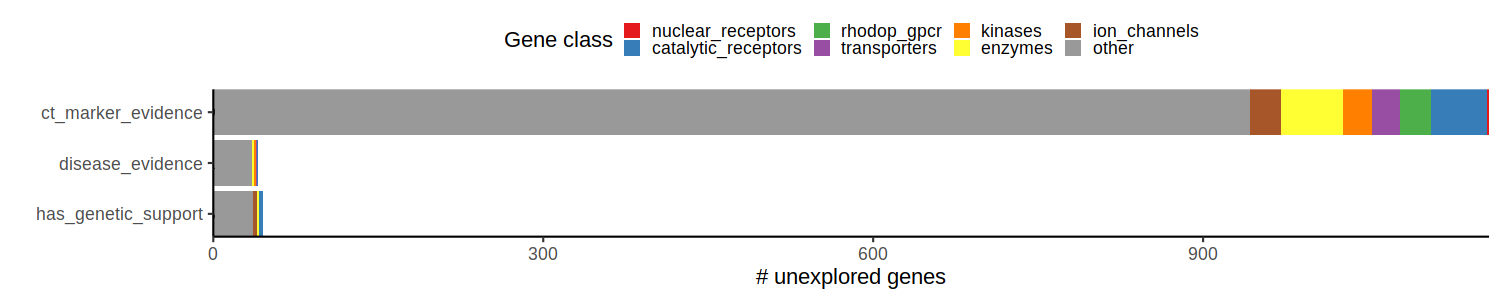

In [139]:
%%R -i targets_pl_df -i frac_pl_df -i evidence_cols -i row_order -w 1500 -h 300
# lapply(c('safe', 'effective', 'approved'), function(success_col){ 
pl1 <- targets_pl_df %>%
    mutate(value= ifelse(value==1, '1', NA)) %>%
    mutate(variable = factor(variable, levels=c(unlist(evidence_cols), 'is_approved', 'is_effective', 'is_safe'))) %>%
    arrange(variable) %>%
    mutate(gene_name=factor(gene_name, levels=row_order)) %>%
    ggplot(aes(gene_name, variable)) +
    geom_tile(aes(fill=value)) +
    geom_point(data=. %>% group_by(gene_name) %>% mutate(variable='target_class', col_class=''), aes(color=gene_class), 
               shape=15, size=5) +
    facet_grid(col_class~success_group, scales='free', space='free') +
    scale_color_manual(values=gene_class_palette, name='Gene class') +
    scale_fill_manual(values=c('black'), na.value="white") +
    theme_classic(base_size=22) +
    ylab('Cell type label') + xlab('Drug target gene') +
    guides(fill='none', color='none') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), 
          strip.text.y = element_text(angle=0, hjust=0),
          strip.background = element_rect(fill = "transparent", color=NA),
           strip.placement = "outside",
            panel.border = element_rect(color = "black", fill = NA)) 

# pl1 + ggsave_figdir('PulmEmph_explored_targets', width=10, height=5)
pl1 + ggsave('~/PulmEmph_explored_targets.pdf', width=8, height=4)

pl2 <- frac_pl_df %>%
    mutate(variable = factor(variable, levels=c('has_genetic_support', 'disease_evidence', 'ct_marker_evidence'))) %>%
    group_by(variable) %>%
    mutate(n = sum(value)) %>%
    ggplot(aes(variable, value)) +
#     geom_col(aes(fill=gene_class), position='fill') +
    geom_col(aes(fill=gene_class)) +
    geom_text(data = . %>% distinct(n, variable),
              aes(y=1.2, label=paste('n =', n)), size=6, hjust=1) +
    scale_fill_manual(values=gene_class_palette, name='Gene class') +
    theme_classic(base_size=22) +
    ylab('# unexplored genes') + xlab('') +
    coord_flip(expand=FALSE) +
    theme(legend.position='top')

# pl2 + ggsave_figdir('PulmEmph_fraction_unexplored', width=12, height=3)

pl2 + ggsave('~/PulmEmph_fraction_unexplored.pdf', width=8, height=3)

In [ ]:
targets_res_coarse['target_disease'] = targets_res_coarse['gene_id'] + "_" + targets_res_coarse['disease_ontology_id']
evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']
evidence_sets_dict = {}
for ev in evidence_cols:
    evidence_sets_dict[ev] = targets_res_coarse.target_disease[
        (targets_res_coarse[ev] == 1)
    ].tolist()

evidence_upset = upsetplot.from_contents(evidence_sets_dict)

pl = upsetplot.UpSet(
    evidence_upset, 
    orientation='vertical', 
    show_counts = '{:d}', 
    sort_categories_by='cardinality',
    sort_by='cardinality', 
)
pl.plot()

In [ ]:
all_other_enr = pd.DataFrame()
evidence_cols = ['has_genetic_support', 'disease_evidence', 'ct_marker_evidence']

for ev in evidence_cols:
    other_enr = enrichment_analysis(
        targets_res_coarse, 
        filter_evidence = dict({(x,1) if x==ev else (x,0) for x in evidence_cols}), 
        filter_gene_class=GENE_CLASS_ORDER,
        fdr_alpha=1
    )
    other_enr['evidence'] = ev
    all_other_enr = pd.concat([all_other_enr, other_enr])

In [196]:
all_other_enr['top10_genes'] = [';'.join(x[0:10]) for x in all_other_enr['genes'].str.split(";")]
all_other_enr_signif = all_other_enr[all_other_enr['adj_pval'] < 0.05]
all_other_enr_signif = all_other_enr_signif[[len(x) > 1 for x in all_other_enr_signif['top10_genes'].str.split(";")]].copy()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


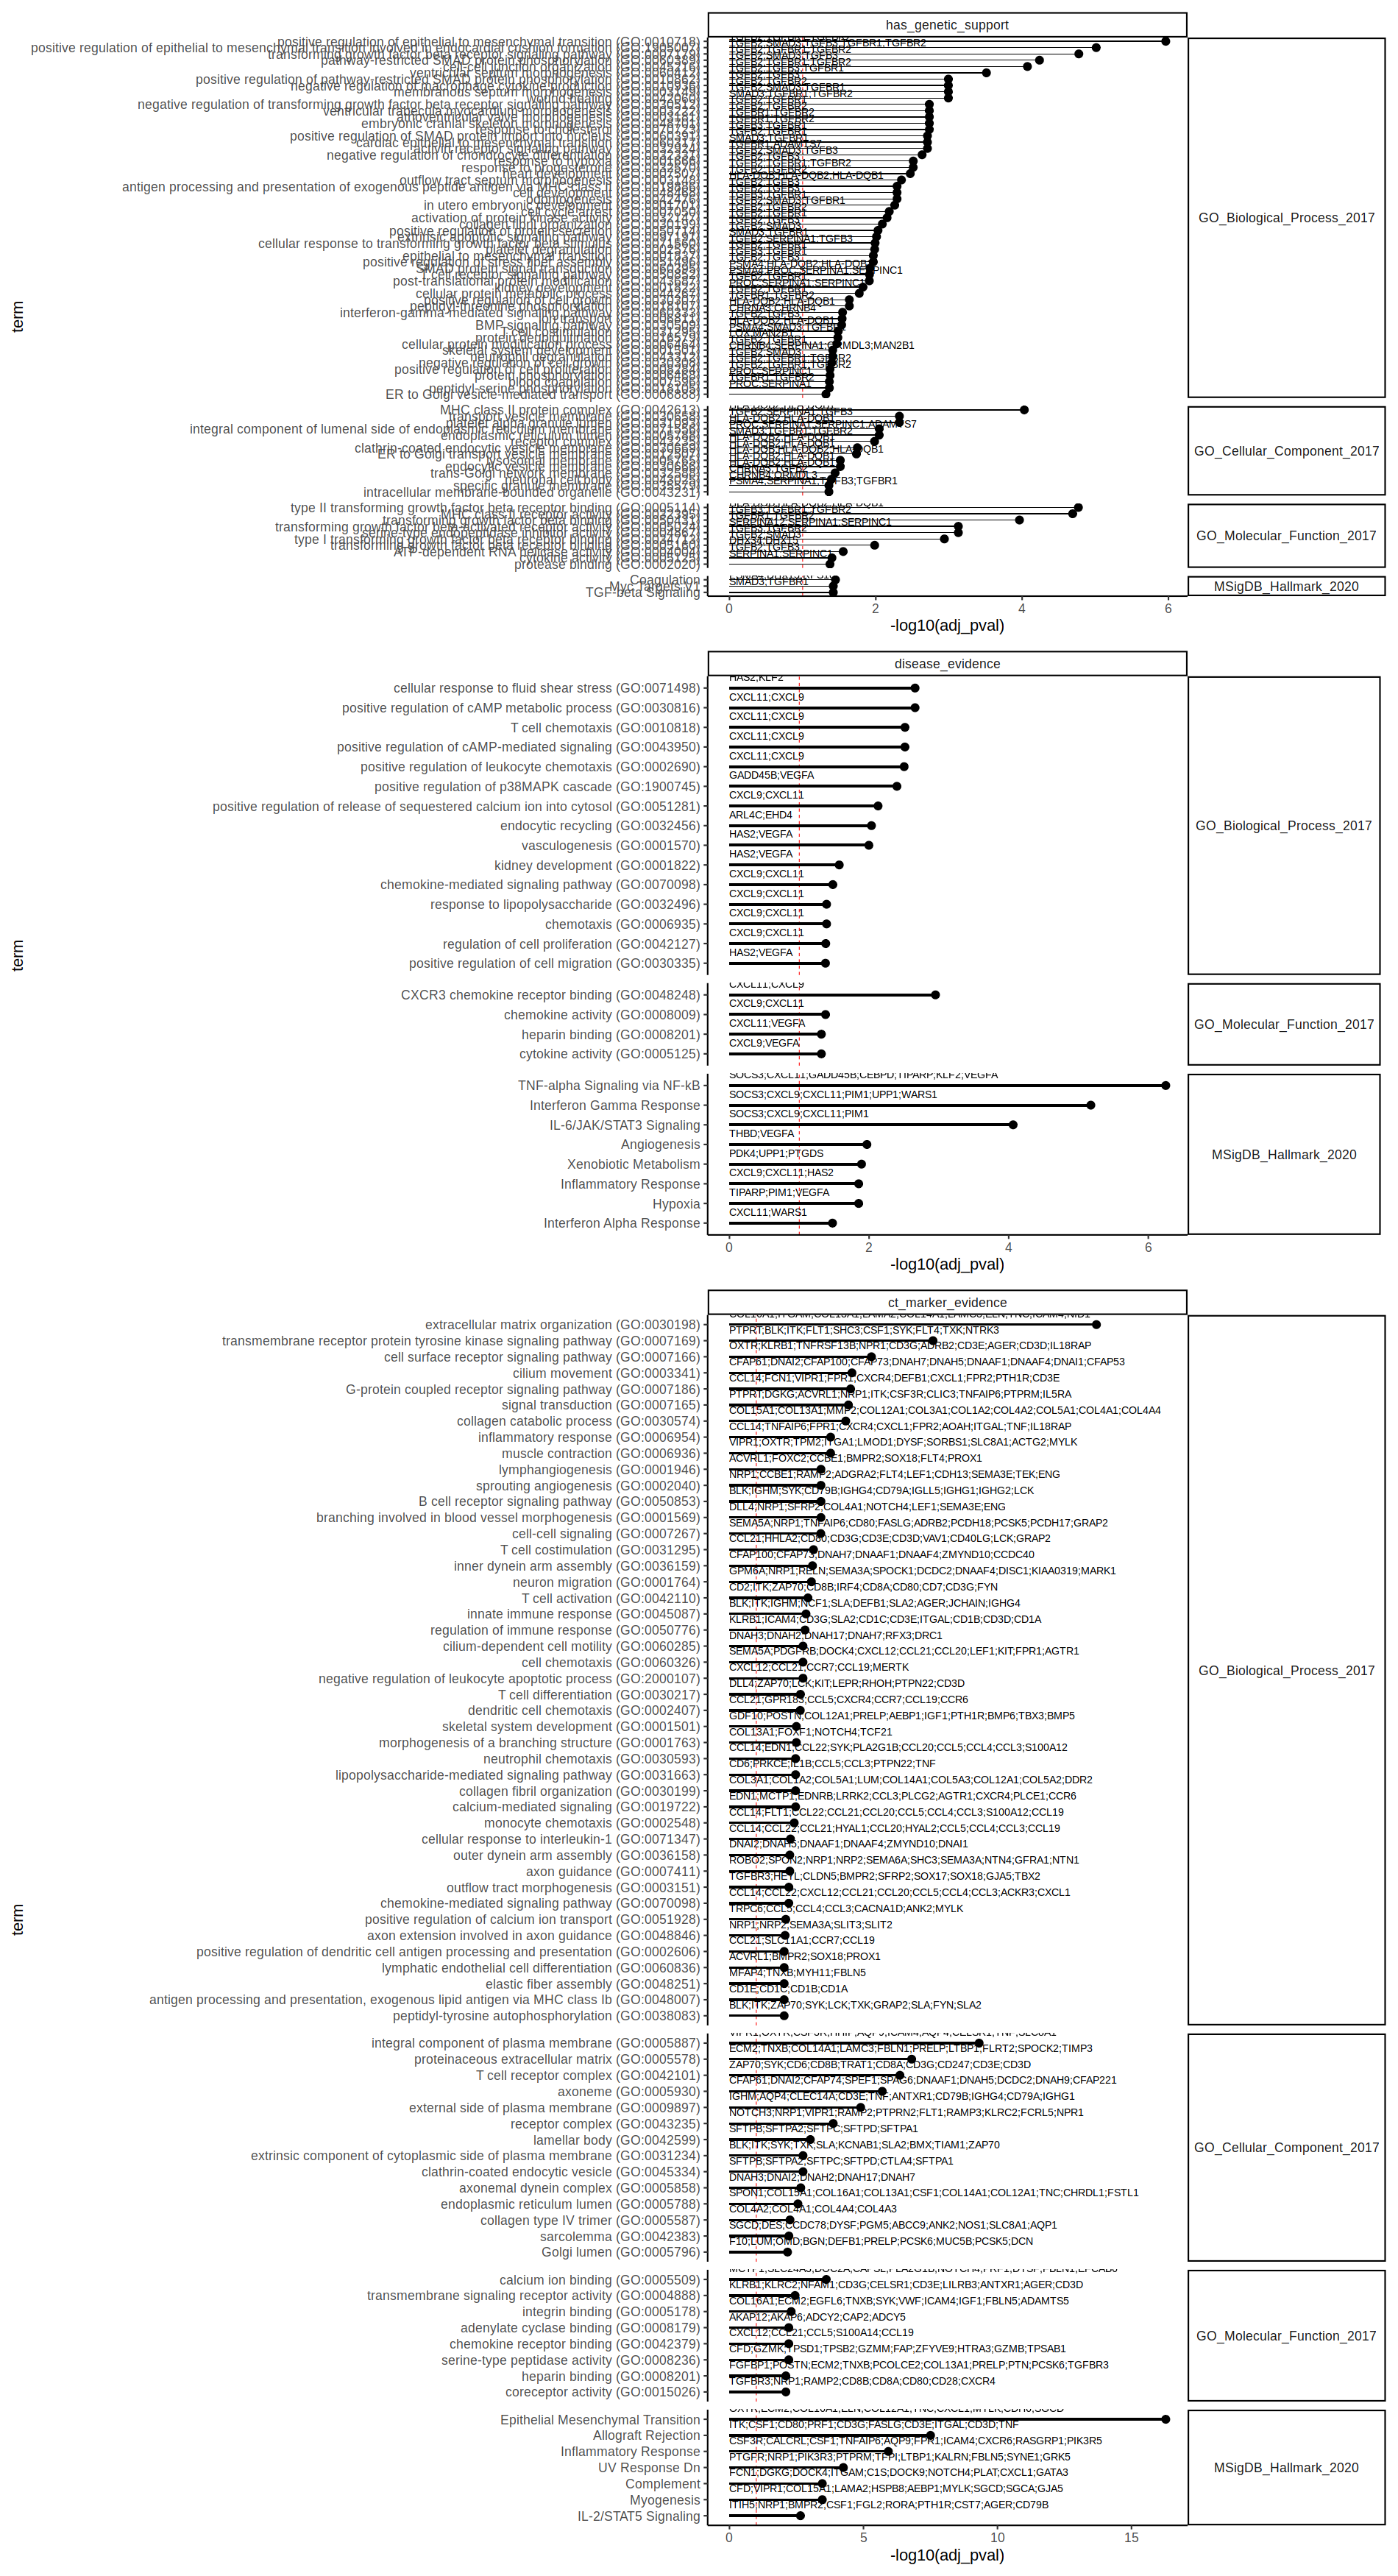

In [199]:
%%R -i all_other_enr_signif -w 1900 -h 3500 
p1 <- all_other_enr_signif %>%
    filter(evidence == 'has_genetic_support') %>%
    arrange( - adj_pval) %>%
    mutate(term = factor(term, levels=term)) %>%
    ggplot(aes(-log10(adj_pval), term)) +
    geom_vline(xintercept=1, linetype=2, color='red') +
    geom_col(width=0.15, fill='black') +
    geom_point(size=5) +
    geom_text(aes(x=0, label=top10_genes), size=5, vjust=-1, hjust=0) +
#     xlim(0,25) +
    theme_classic(base_size=22) +
    facet_grid(gene_set~evidence, scales='free', space='free') +
    theme(strip.text.y = element_text(angle=0)) 
p2 <- all_other_enr_signif %>%
    filter(evidence == 'disease_evidence') %>%
#     slice_min(adj_pval, n=10) %>%
    arrange( - adj_pval) %>%
    mutate(term = factor(term, levels=term)) %>%
    ggplot(aes(-log10(adj_pval), term)) +
    geom_vline(xintercept=1, linetype=2, color='red') +
    geom_col(width=0.15, fill='black') +
    geom_point(size=5) +
    geom_text(aes(x=0, label=top10_genes), size=5, vjust=-1, hjust=0) +
#     xlim(0,25) +
    theme_classic(base_size=22) +
    facet_grid(gene_set~evidence, scales='free', space='free') +
    theme(strip.text.y = element_text(angle=0)) 
p3 <- all_other_enr_signif %>%
    filter(evidence == 'ct_marker_evidence') %>%
#     slice_min(adj_pval, n=10) %>%
    arrange( - adj_pval) %>%
    filter(adj_pval < 0.01) %>%
    mutate(term = factor(term, levels=term)) %>%
    ggplot(aes(-log10(adj_pval), term)) +
    geom_vline(xintercept=1, linetype=2, color='red') +
    geom_col(width=0.15, fill='black') +
    geom_point(size=5) +
    geom_text(aes(x=0, label=top10_genes), size=5, vjust=-1, hjust=0) +
#     xlim(0,25) +
    theme_classic(base_size=22) +
    facet_grid(gene_set~evidence, scales='free', space='free') +
    theme(strip.text.y = element_text(angle=0)) 
    
(p1 / p2 / p3) +
plot_layout(heights=c(0.6,0.6,1.3))

In [103]:
pbulk_adata_coarse.var_names = pbulk_adata_coarse.var['feature_name'].values

In [83]:
hlca_adata = sc.read_h5ad('../data/HLCA_annotation_cellxgene_targets_MONDO_0005002.pbulk_all_genes.h5ad', backed=False)
hlca_adata = hlca_adata[hlca_adata.obs['disease'] == 'normal'].copy()
hlca_adata.var_names = hlca_adata.var['feature_name'].values

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:895: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [84]:
hlca_adata = _process_pbulk(hlca_adata)

In [64]:
# sc.pp.highly_variable_genes(hlca_adata, layer='logcounts')
# hlca_adata.X = hlca_adata.layers['logcounts'].copy()
# sc.tl.pca(hlca_adata,  use_highly_variable=True)
# sc.tl.dendrogram(hlca_adata, groupby='plot_ct_id')

In [85]:
logcount_data_1 = hlca_adata.layers['logcounts'].data

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


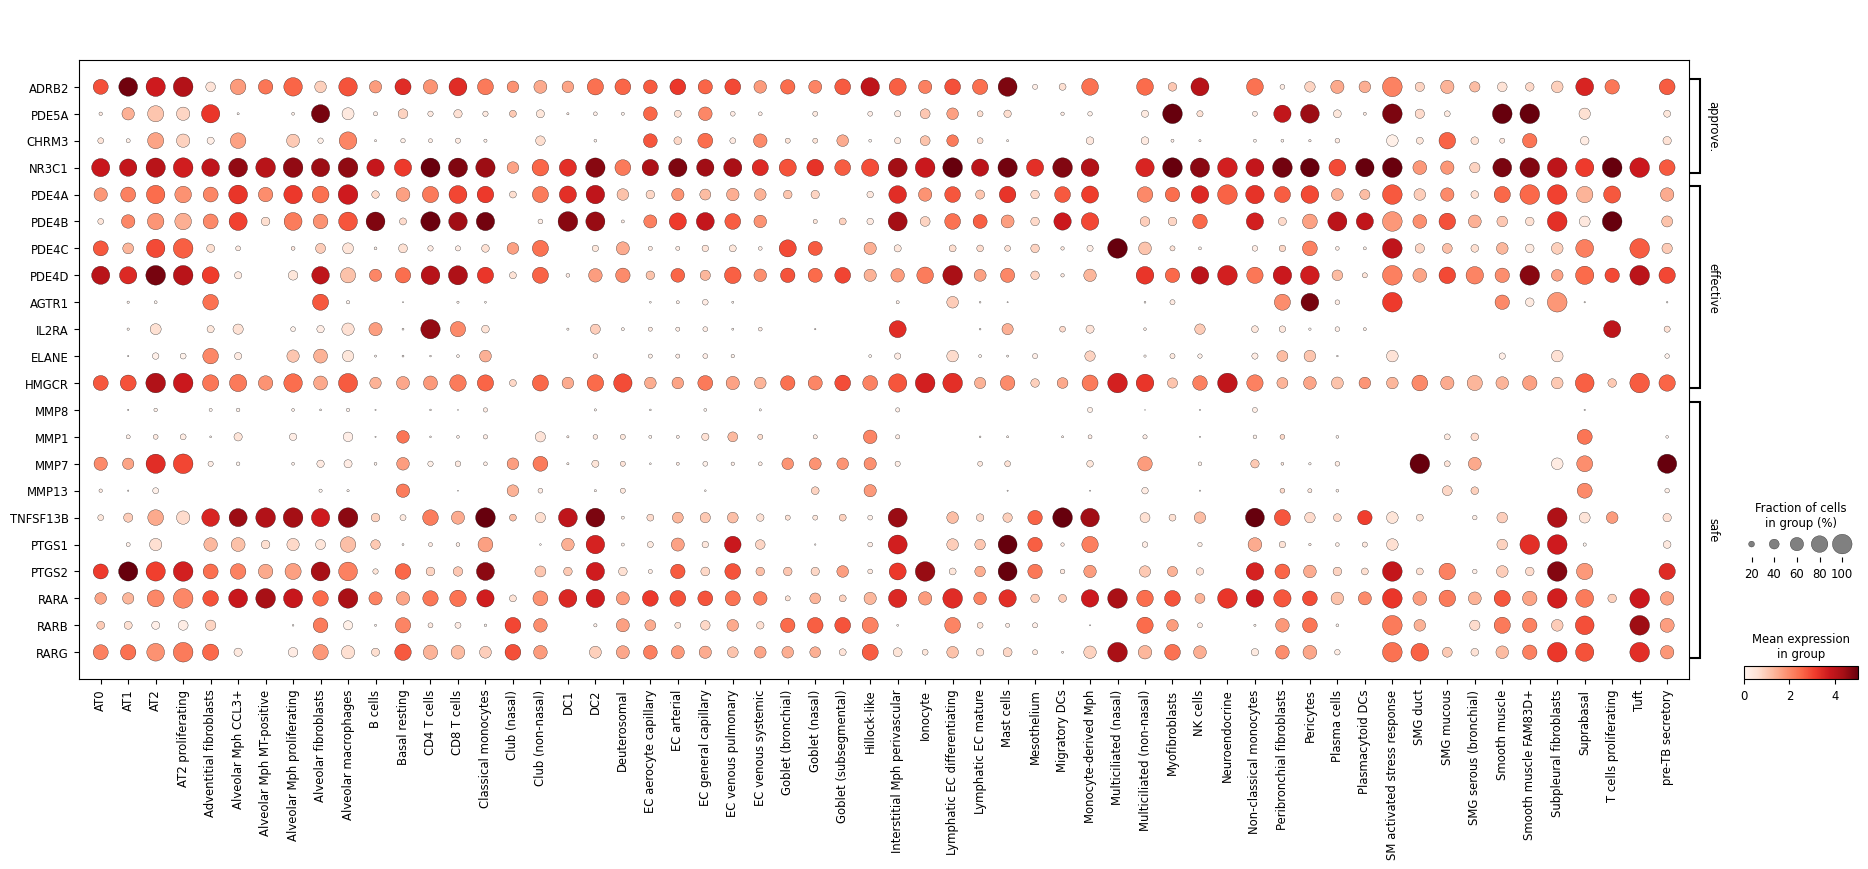

In [86]:
sc.pl.dotplot(hlca_adata, targets_dict, groupby='plot_ct_id', layer='logcounts', vmax=5, swap_axes=True)

In [79]:
hlca_adata.obs = pd.merge(hlca_adata.obs, ann_df)
logcount_data_3 = hlca_adata.layers['logcounts'].data

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [81]:
all(logcount_data_3 == logcount_data_2)

True

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


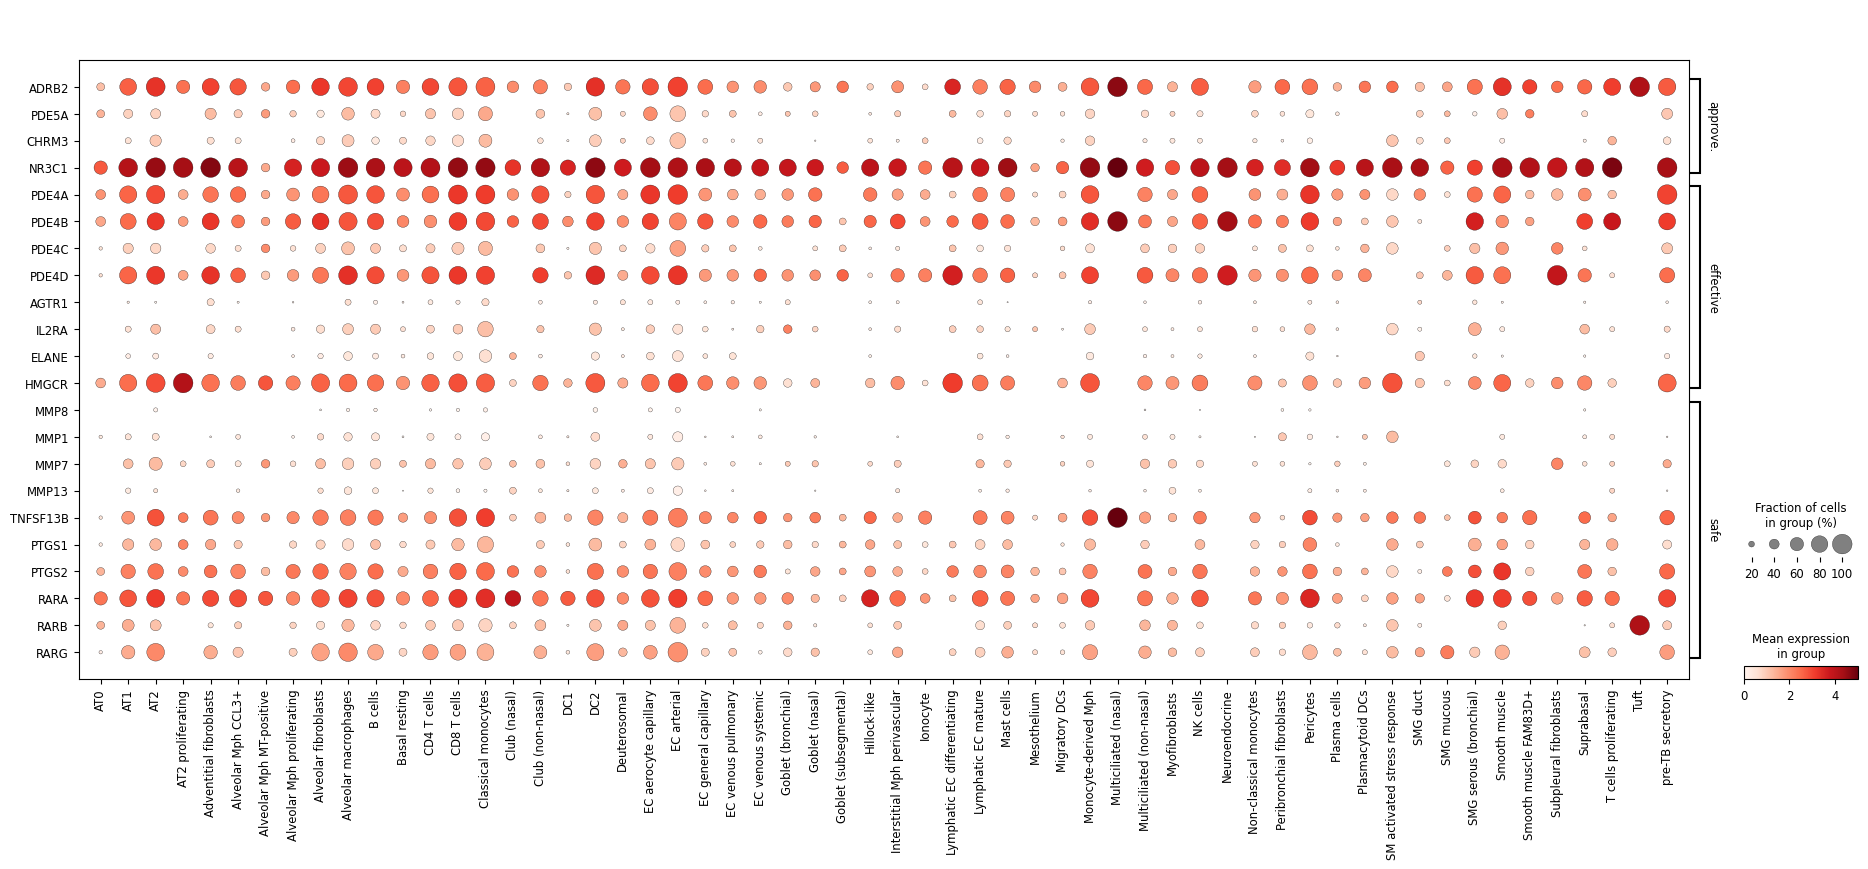

In [82]:
sc.pl.dotplot(hlca_adata, targets_dict, groupby='plot_ct_id', layer='logcounts', vmax=5, swap_axes=True)

In [32]:
hlca_adata_full = sc.read_h5ad('../data/hlca_census.h5ad', backed=True)


In [91]:
ann_df = hlca_adata_full.obs[['ann_level_3', 'ann_finest_level']].drop_duplicates().sort_values('ann_level_3')
ann_df = ann_df.rename({'ann_finest_level':'plot_ct_id'}, axis=1)
ann_df = ann_df.dropna()
ann_df['ann_level_3'] = np.where(ann_df['ann_level_3'] == 'None', ann_df['plot_ct_id'], ann_df['ann_level_3'])
annot_dict = ann_df.groupby(['ann_level_3'])['plot_ct_id'].apply(list).to_dict()
reversed_annot_dict = {value: key for key, values in annot_dict.items() for value in values}

In [102]:
hlca_adata = sc.read_h5ad('../data/HLCA_annotation_cellxgene_targets_MONDO_0005002.pbulk_all_genes.h5ad', backed=False)
hlca_adata = hlca_adata[hlca_adata.obs['disease'] == 'normal'].copy()
hlca_adata.var_names = hlca_adata.var['feature_name'].values
hlca_adata = _process_pbulk(hlca_adata)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:895: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [103]:
hlca_adata.obs['grouped_annot'] = [reversed_annot_dict[x] for x in hlca_adata.obs['plot_ct_id']]

In [104]:
hlca_adata.obs['total_counts'] = hlca_adata.obs['size_factors'].copy()

In [105]:
from sc_target_evidence_utils.preprocessing_utils import anndata2pseudobulk
grouped_hlca_adata = anndata2pseudobulk(hlca_adata, group_by=['donor_id', 'grouped_annot'], min_ncells=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
_process_pbulk(grouped_hlca_adata)

In [107]:
grouped_hlca_adata.obs['grouped_annot'] = grouped_hlca_adata.obs['grouped_annot'].astype('category')

In [108]:
sc.pp.highly_variable_genes(grouped_hlca_adata, layer='logcounts')
grouped_hlca_adata.X = grouped_hlca_adata.layers['logcounts'].copy()
sc.tl.pca(grouped_hlca_adata,  use_highly_variable=True)
sc.tl.dendrogram(grouped_hlca_adata, groupby='grouped_annot')

categories: AT1, AT2, B cell lineage, etc.
var_group_labels: approved, effective, safe


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


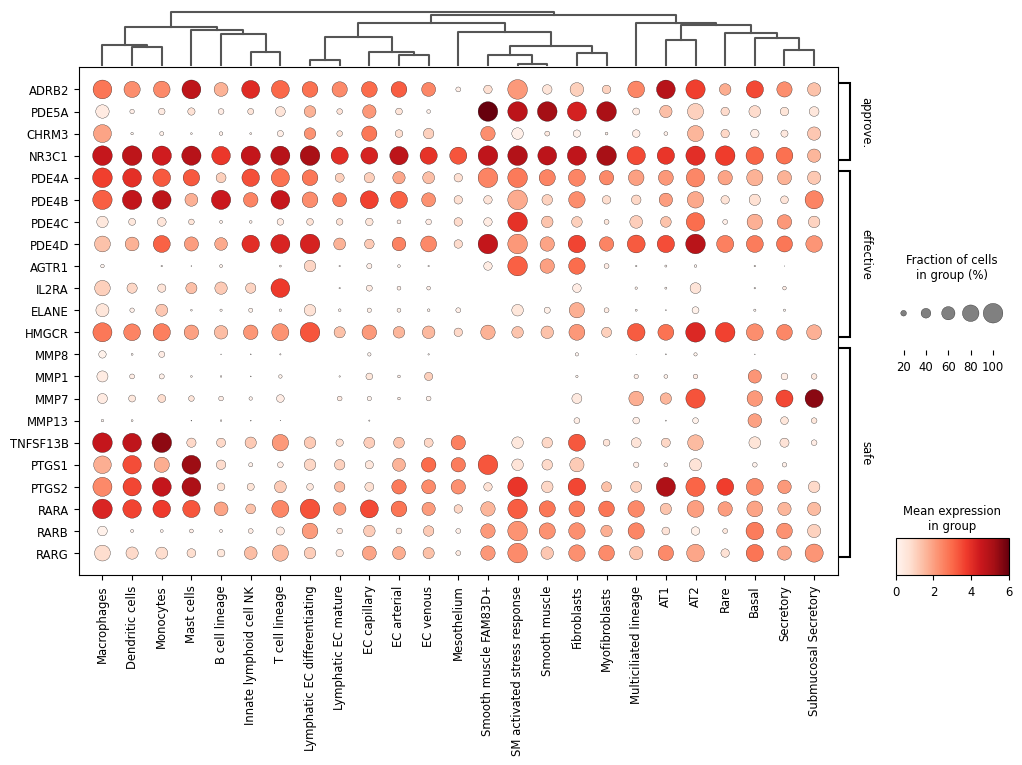

In [128]:
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

sc.pl.dotplot(grouped_hlca_adata, targets_dict, vmax=6,
              groupby='grouped_annot', 
              layer='logcounts', dot_min=0.01,
              dendrogram=True,
              swap_axes=True, figsize=(10,7), save='dotplot_emphysema.svg')

categories: AT1, AT2, B cell lineage, etc.
var_group_labels: approved, effective, safe


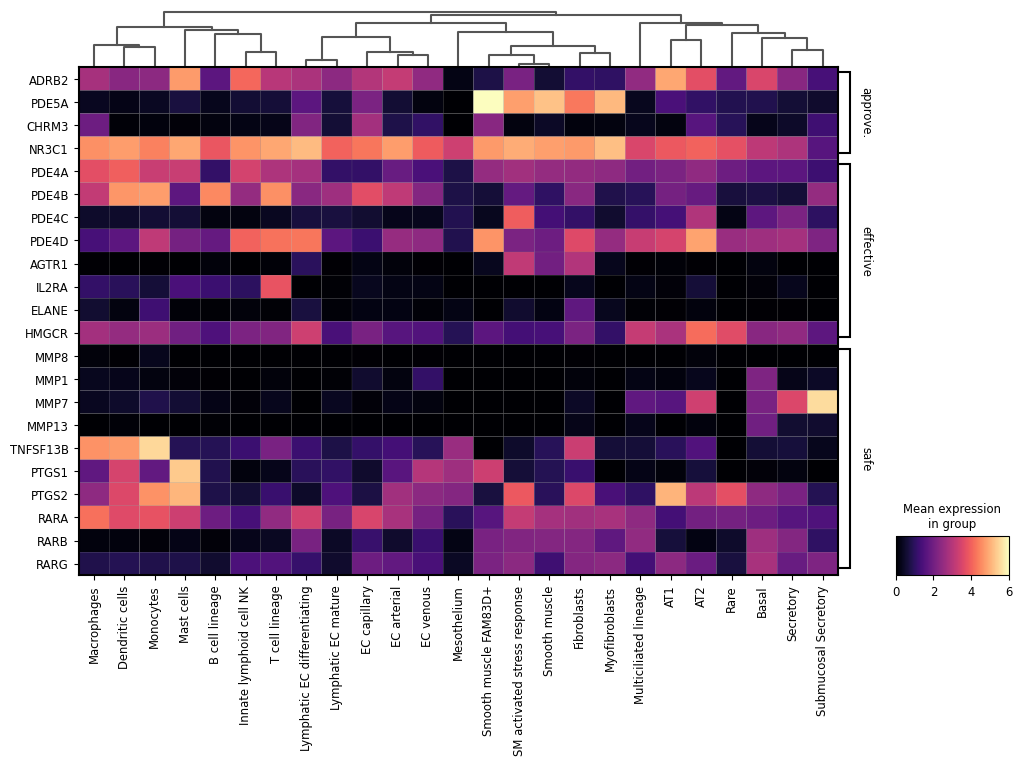

In [125]:
sc.pl.matrixplot(grouped_hlca_adata, targets_dict, vmax=6,
              groupby='grouped_annot', 
              layer='logcounts', 
              dendrogram=True, cmap='magma',
              swap_axes=True, figsize=(12,7), save='emphysema.svg')

In [104]:
# sc.pp.highly_variable_genes(pbulk_adata_coarse, layer='logcounts')
# pbulk_adata_coarse.X = pbulk_adata_coarse.layers['logcounts'].copy()
# sc.tl.pca(pbulk_adata_coarse,  use_highly_variable=True)

# sc.tl.dendrogram(pbulk_adata_coarse, groupby='high_level_cell_type')

# targets_dict = targets_pl_df[['gene_name', 'success_group']].drop_duplicates().sort_values('success_group').groupby('success_group')['gene_name'].agg(list).to_dict()

# targets = targets_res_coarse[targets_res_coarse['is_safe']==1].gene_name.tolist()

In [88]:
pbulk_adata_coarse.var_names = pbulk_adata_coarse.var['feature_name'].values

categories: fibroblast (CL:0000057), ciliated cell (CL:0000064), epithelial cell (CL:0000066), etc.
var_group_labels: approved, effective, safe


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


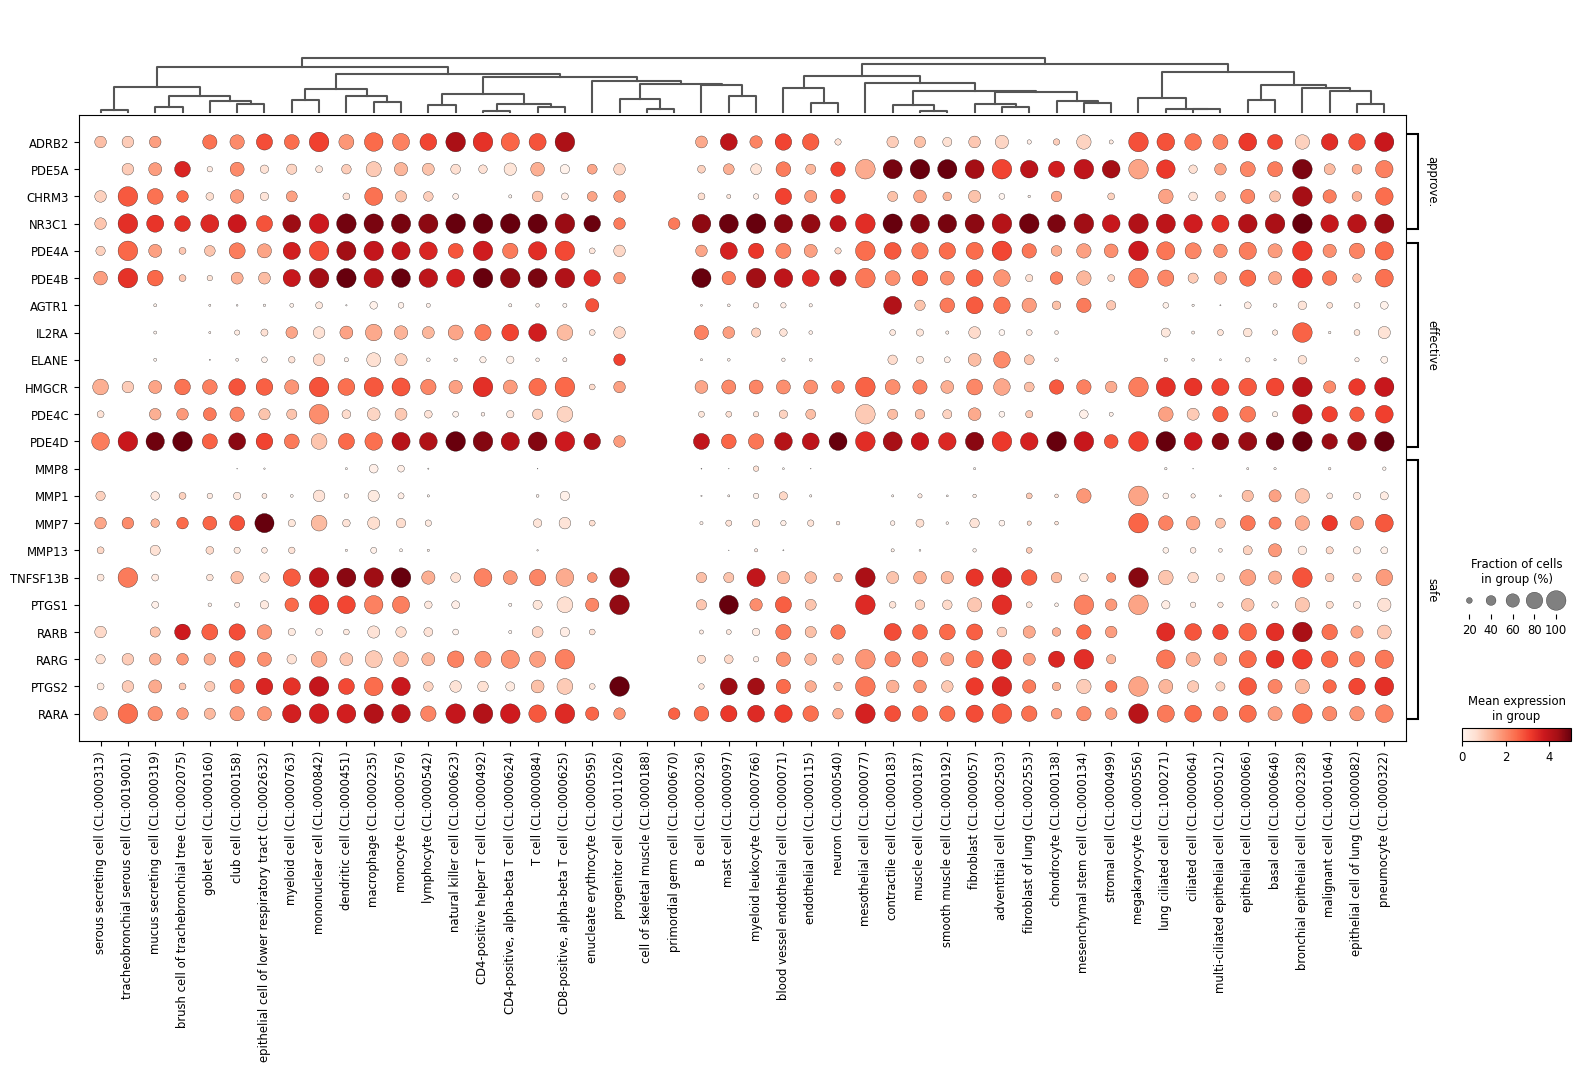

In [103]:
# targets = targets_res_coarse[targets_res_coarse['is_safe']==1].gene_name.tolist()
sc.pl.dotplot(pbulk_adata_coarse[pbulk_adata_coarse.obs['disease'] == 'normal'], targets_dict, 
                 groupby='high_level_cell_type', layer='logcounts', dendrogram=True, swap_axes=True, vmax=5)

In [120]:
pick_assay = "10x 3' v3"
pick_susp = 'cell'

filter_pbulk_adata = pbulk_adata_coarse[(pbulk_adata_coarse.obs['assay'] == pick_assay) & (pbulk_adata_coarse.obs['suspension_type'] == pick_susp)].copy()

(0.0, 2000.0)

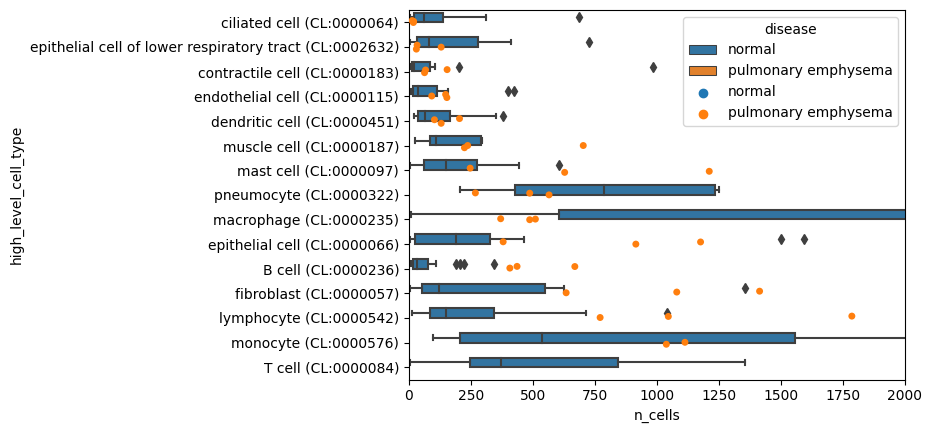

In [126]:
# df = pbulk_adata_coarse.obs[['disease', 'high_level_cell_type','donor_id', 'n_cells']].groupby(['disease', 'high_level_cell_type']).mean().reset_index()
df = filter_pbulk_adata.obs[['disease', 'high_level_cell_type', 'n_cells']]
keep_cts = df[df.disease != 'normal'].dropna().sort_values('n_cells').high_level_cell_type.unique()
df = df[df.high_level_cell_type.isin(keep_cts)]

# # sns.pointplot(y='high_level_cell_type', x='n_cells', hue='disease', data=df, order=keep_cts)
sns.boxplot(data=df[df.disease == 'normal'], x='n_cells', y='high_level_cell_type', hue='disease', order=keep_cts);
sns.stripplot(data=df[df.disease != 'normal'], x='n_cells', y='high_level_cell_type', hue='disease', order=keep_cts);
plt.xlim(0, 2000)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


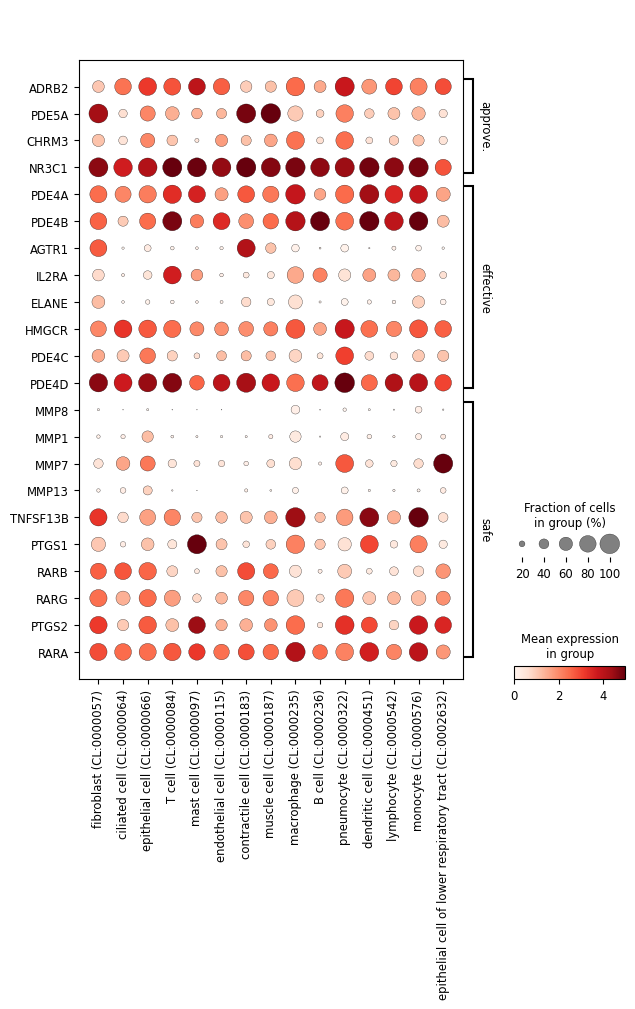

In [125]:
# targets = targets_res_coarse[targets_res_coarse['is_safe']==1].gene_name.tolist()
sc.pl.dotplot(pbulk_adata_coarse[(pbulk_adata_coarse.obs['disease'] == 'normal') & (pbulk_adata_coarse.obs['high_level_cell_type'].isin(keep_cts))], targets_dict, 
                 groupby='high_level_cell_type', layer='logcounts', swap_axes=True, vmax=5)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


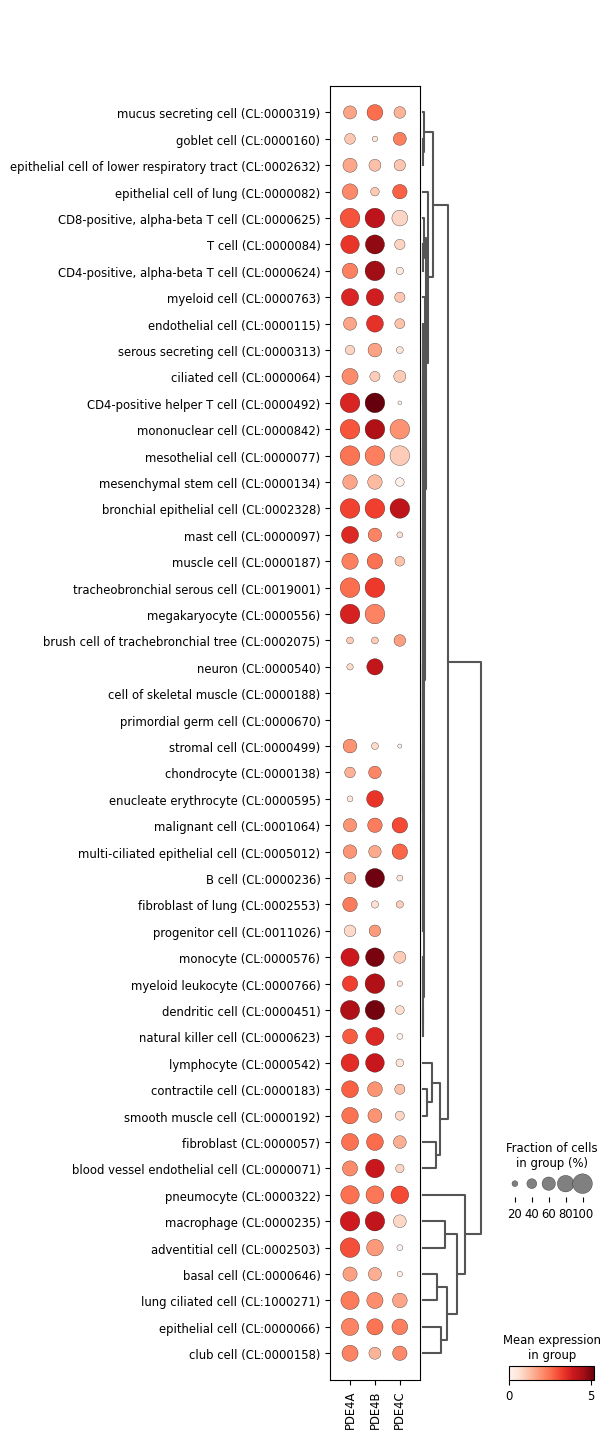

In [68]:
sc.pl.dotplot(hlca_adata_[pbulk_adata_coarse.obs['disease'] == 'normal'], ['PDE4A', 'PDE4B', 'PDE4C'], groupby='high_level_cell_type', layer='logcounts', dendrogram=True)